In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from tslearn.metrics import dtw_path
import matplotlib.animation as animation
import stumpy

In [2]:
alldf = pd.read_csv('/Users/maxingjian/Desktop/Eye tracking data analysis/combined data/IDBY01.csv')
alldf['rec_time_s'] =  pd.to_datetime(alldf['rec_time'], format="%H:%M:%S.%f")
alldf['rec_time_s'] = alldf['rec_time_s'] - pd.to_datetime("1900-01-01", format="%Y-%m-%d")
alldf['rec_time_s'] =  (alldf['rec_time_s']).dt.total_seconds()
alldf['rec_time_s'] = alldf['rec_time_s'].interpolate(limit_direction = 'both')
alldf['Simulator_XPosition'] = alldf['Simulator_XPosition'].interpolate(limit_direction = 'both')

cols = ['TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Pupil.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Pupil.Y',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Pupil.Z',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Gaze.Direction_Gaze.Direction.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Gaze.Direction_Gaze.Direction.Y',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Gaze.Direction_Gaze.Direction.Z',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Pupil.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Pupil.Y',	
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Pupil.Z',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Gaze.Direction_Gaze.Direction.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Gaze.Direction_Gaze.Direction.Y',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Gaze.Direction_Gaze.Direction.Z',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position.3D_Gaze.X',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position.3D_Gaze.Y',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position.3D_Gaze.Z',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y']

for i in np.arange(len(cols)):
    alldf.loc[alldf[cols[i]]==0,cols[i]] = np.nan 

alldf[cols] = alldf[cols].interpolate(limit_direction = 'both')
alldf[cols].isna().sum().sum()

0

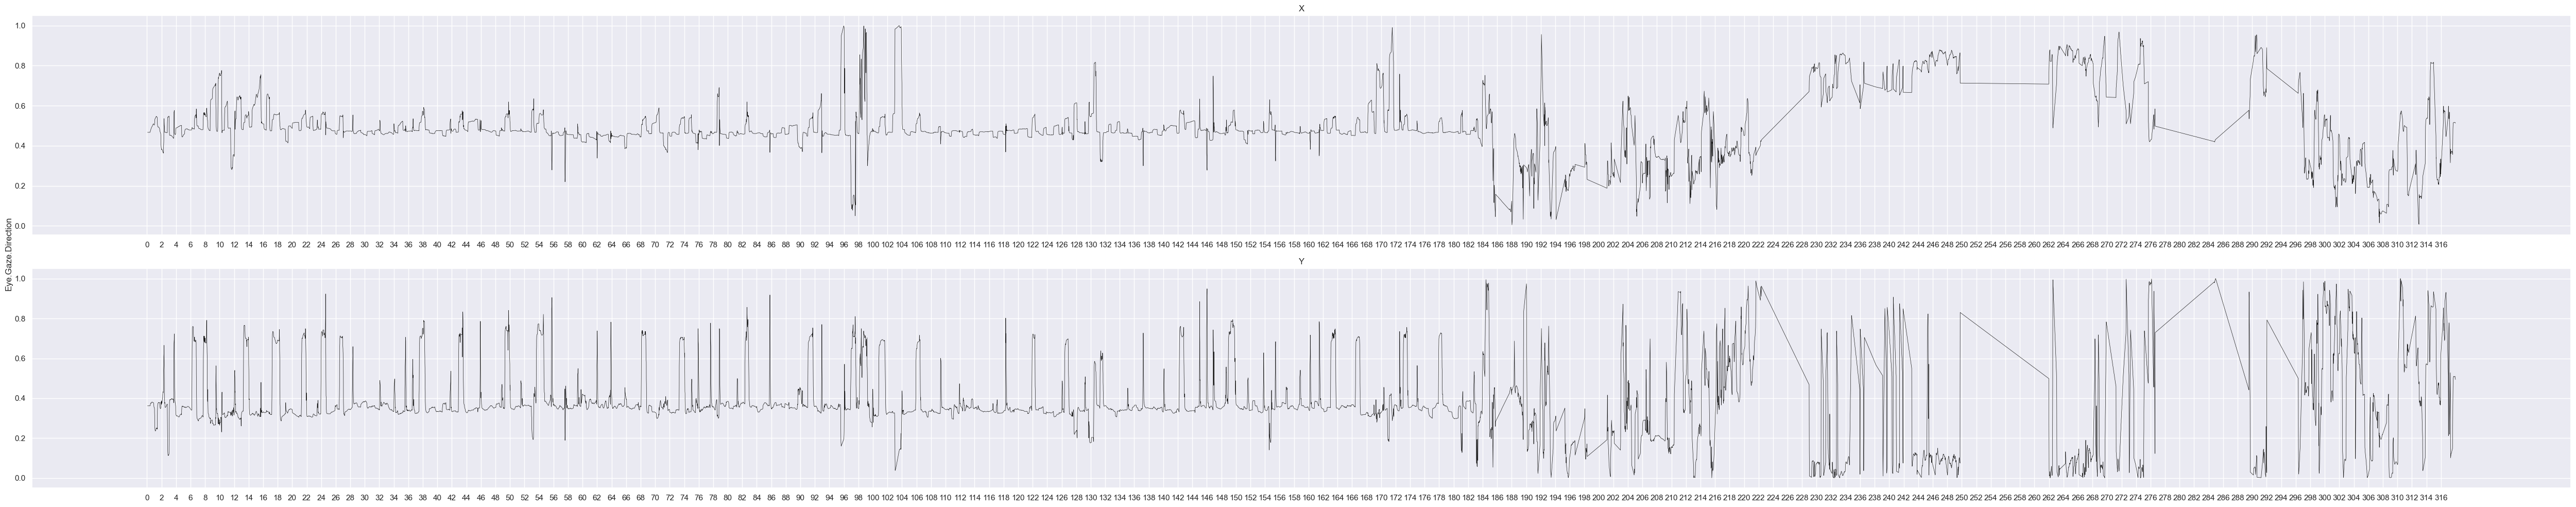

In [4]:
############################
# Visualization of X and Y #
############################

tempdf = alldf[(alldf.Subject == 'IDBY01') & (alldf.Drive == 'Drive1')]

sns.set(rc={'figure.figsize':(50,10)})
fig, axes = plt.subplots(2, 1)
axes[0].set_title('X')
axes[1].set_title('Y')
axes[0].plot(tempdf["rec_time_s"], tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X"], linewidth=0.5, color='k')
axes[1].plot(tempdf["rec_time_s"], tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y"], linewidth=0.5, color='k')
axes[0].set_xticks(np.arange(0,max(tempdf["rec_time_s"]),2))
axes[1].set_xticks(np.arange(0,max(tempdf["rec_time_s"]),2))
for ax in axes.flatten(): ax.set(ylabel=None)
fig.text(0.0, 0.5, 'Eye.Gaze.Direction', va='center', rotation='vertical')
plt.tight_layout()
# plt.savefig("preliminary/IDBY01_D1_Lengthened.png", dpi = 300, bbox_inches='tight')

{'Front.Shield.1', 'Right.Side.Mirror.1', 'Left.Side.Mirror.1', 'AOI.Invalid', 'Rearview.Mirror.1', 'Dashboard.1'}


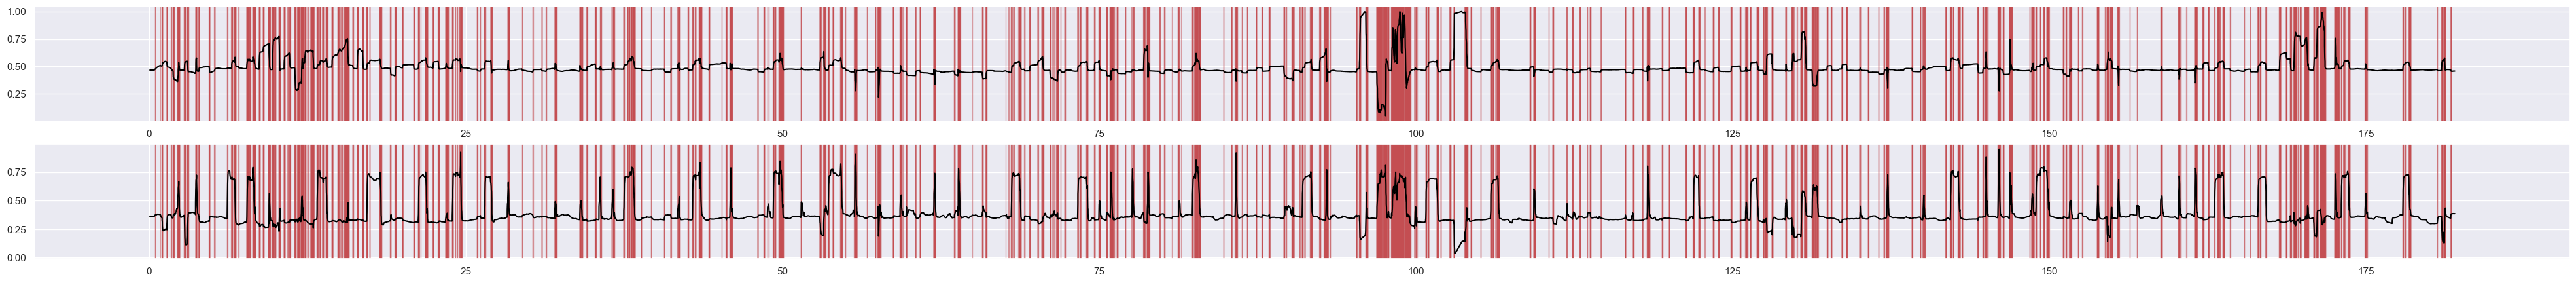

In [5]:
#######################
# Building dictionary #
#######################
m = 95 # window size
k = 10 # number of patterns in a dictionary

tempdf = alldf[(alldf.Subject == 'IDBY01') & (alldf.Drive == 'Drive1')]
tempdf = tempdf[tempdf.rec_time_s<=182] #based on the visualization above, we will take into account only time<182seconds
Tx = np.array(tempdf['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X'])
Ty = np.array(tempdf['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y'])


aoi_cols = ['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Front.Shield.1',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Dashboard.1',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Rearview.Mirror.1',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Left.Side.Mirror.1',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Right.Side.Mirror.1']
tempdf['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_AOI.Invalid'] = 1 - tempdf[aoi_cols].max(axis = 1)
aoi_cols.append('TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_AOI.Invalid')

tempdf['aoi_idx'] = tempdf[aoi_cols].idxmax(axis=1)
get_aoi = lambda x: x.split('_')[-1]
tempdf['aoi_idx'] = tempdf['aoi_idx'].apply(get_aoi)
print(set(tempdf['aoi_idx']))


pad_width = (0, int(m * np.ceil(Tx.shape[0] / m) - Tx.shape[0]))
Tx_padded = np.pad(Tx, pad_width, mode="constant", constant_values=np.nan)
Ty_padded = np.pad(Ty, pad_width, mode="constant", constant_values=np.nan)
n_padded = Tx_padded.shape[0]

# we will check only time points whose (x(t)-x(t-diff))>threshold
diff = 2 
xdiff = np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X"])[diff:]-np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X"])[:-diff]
ydiff = np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y"])[diff:]-np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y"])[:-diff]

xwhere = np.where(np.abs(xdiff)>np.quantile(np.abs(xdiff), 0.85))[0]
ywhere = np.where(np.abs(ydiff)>np.quantile(np.abs(ydiff), 0.85))[0]

diffwhere = np.union1d(xwhere,ywhere)
diffwhere = diffwhere[diffwhere<n_padded - m + 1]

sns.set(rc={'figure.figsize':(50,5)})
fig, axs = plt.subplots(2, 1)
for t in xwhere:
    axs[0].axvline(tempdf['rec_time_s'].iloc[t], color='r',ls='-',lw = 1, alpha = 0.5)
    axs[1].axvline(tempdf['rec_time_s'].iloc[t], color='r',ls='-',lw = 1, alpha = 0.5)
axs[0].plot(tempdf['rec_time_s'], Tx, color = 'black')
axs[1].plot(tempdf['rec_time_s'], Ty, color = 'black')
plt.show()

# Calculate matrix profile
Dx = np.empty((len(diffwhere), Tx.shape[0] - m + 1), dtype=np.float64)
for i in np.arange(len(diffwhere)):
    start = diffwhere[i]
    stop = start + m
    S_i = Tx_padded[start:stop]
    Dx[i, :] = stumpy.mass(S_i, Tx, normalize=False, p=2.0)   
    
Dy = np.empty((len(diffwhere), Ty.shape[0] - m + 1), dtype=np.float64)
for i in np.arange(len(diffwhere)):
    start = diffwhere[i]
    stop = start + m
    S_i = Ty_padded[start:stop]
    Dy[i, :] = stumpy.mass(S_i, Ty, normalize=False, p=2.0)   

D = np.sqrt(Dx**2 + Dy**2)
# D = np.maximum(Dx, Dy)
    
snippets_x = np.empty((k, m), dtype=np.float64) # store snippets(patterns) in X movement
snippets_y = np.empty((k, m), dtype=np.float64) # store snippets(patterns) in Y movement
snippets_aoi = np.empty((k, m), dtype='U100') # store aoi of snippets(patterns)
snippets_indices = np.empty(k, dtype=np.int64) # store index of snippets(patterns)
snippets_profiles = np.empty((k, Dx.shape[-1]), dtype=np.float64) # store MP of snippets(patterns)
snippets_areas = np.empty(k, dtype=np.float64) # store area under MP of snippets(patterns)

indices = diffwhere
mask = np.full(Tx.shape, -np.inf) # array to store which pattern the time point corresponds to
Tx_process = Tx.copy()
Ty_process = Ty.copy()
D_plot = D.copy()
mask_list = []

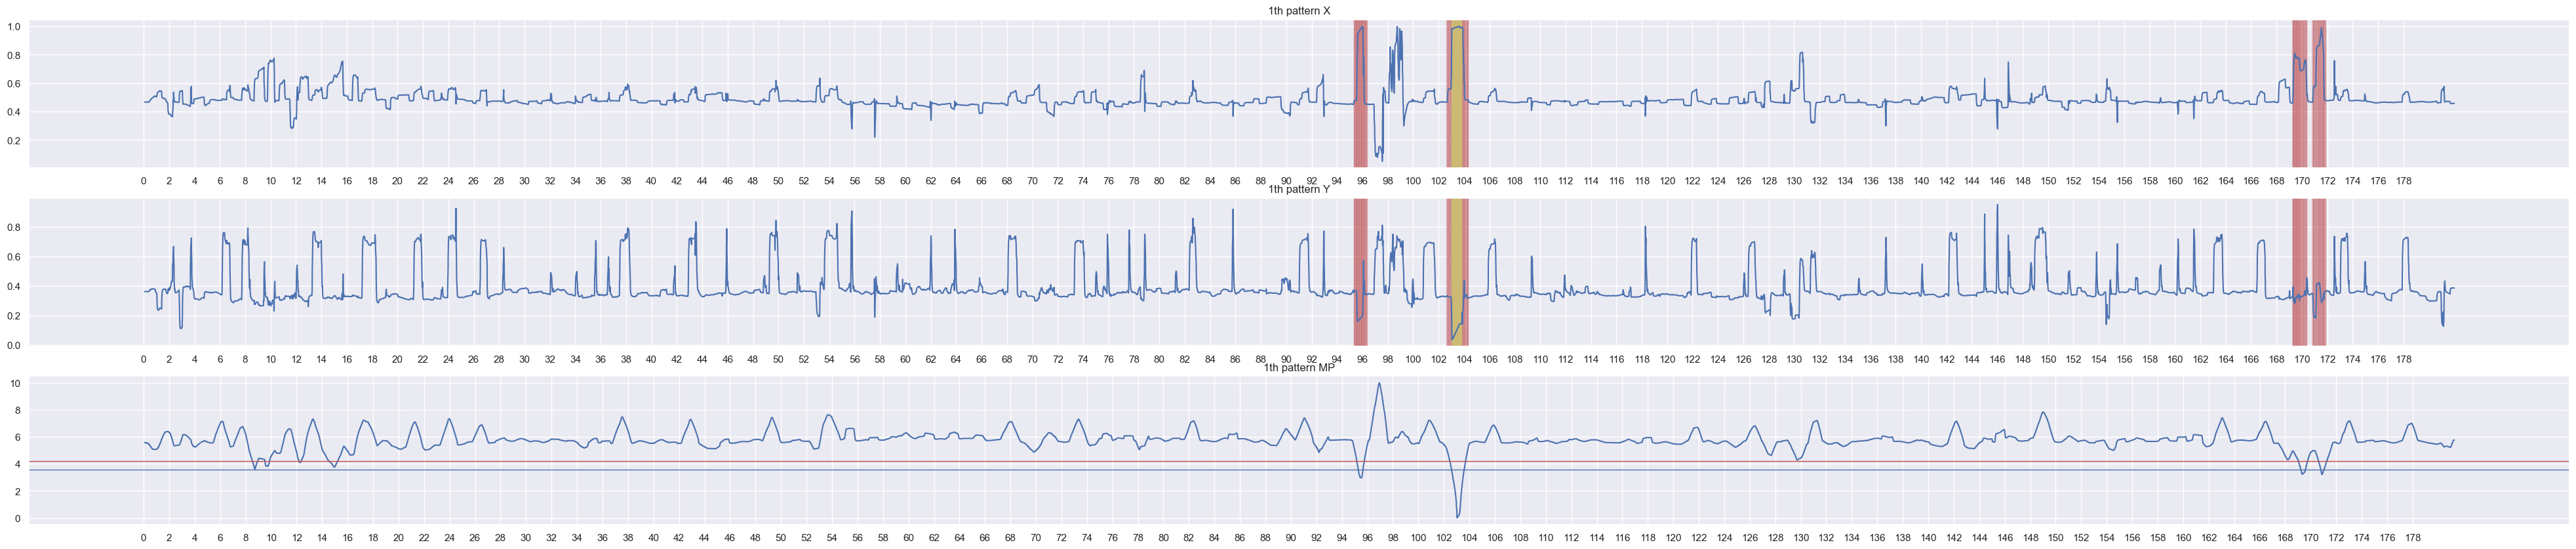

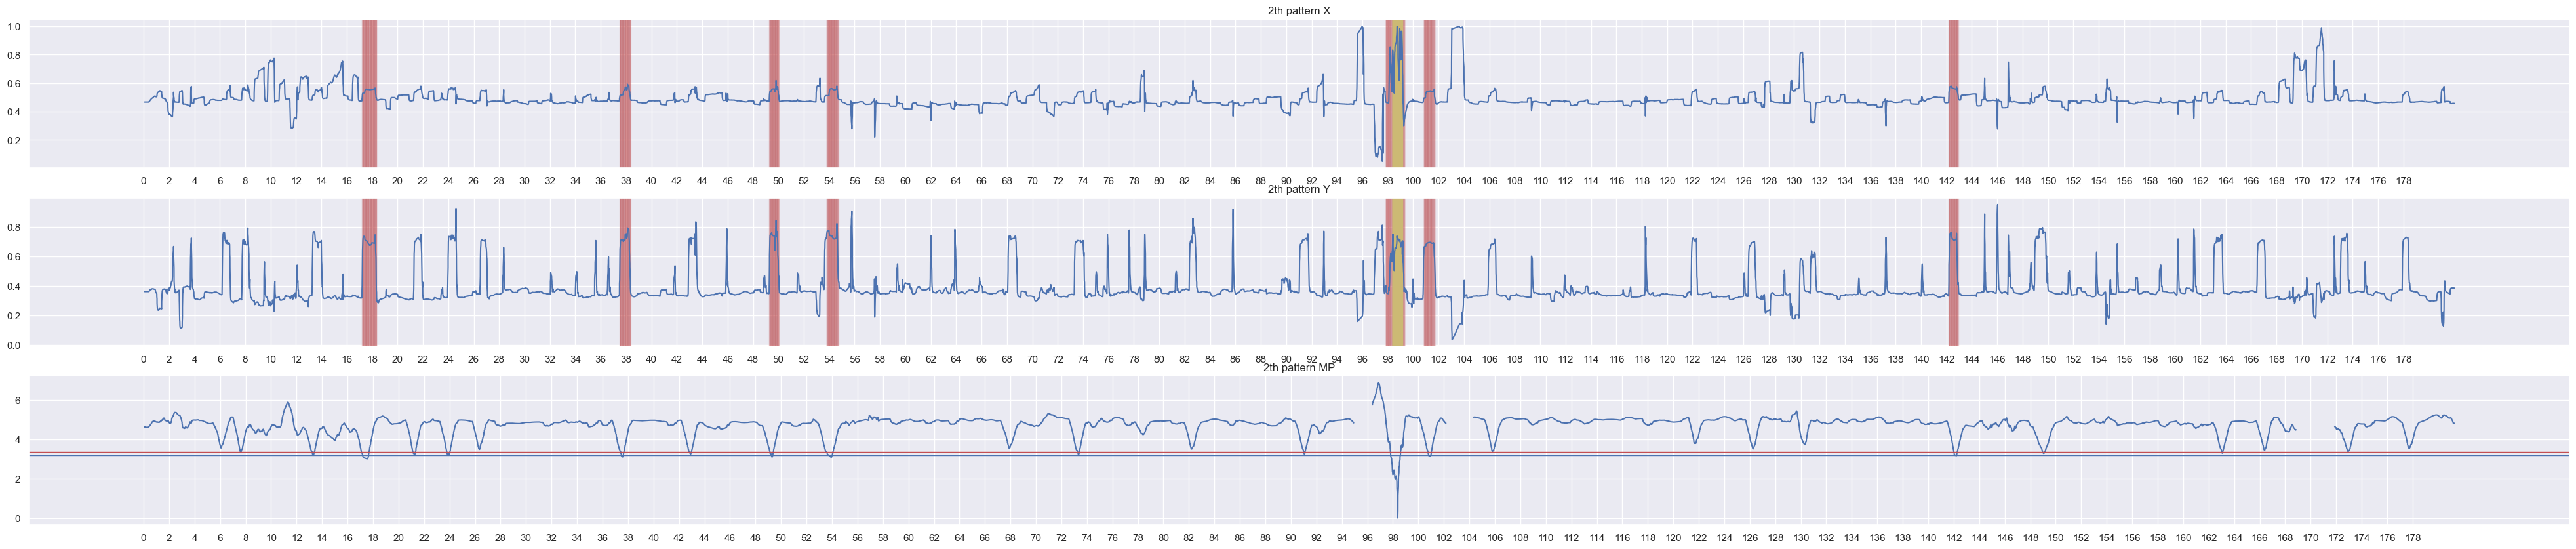

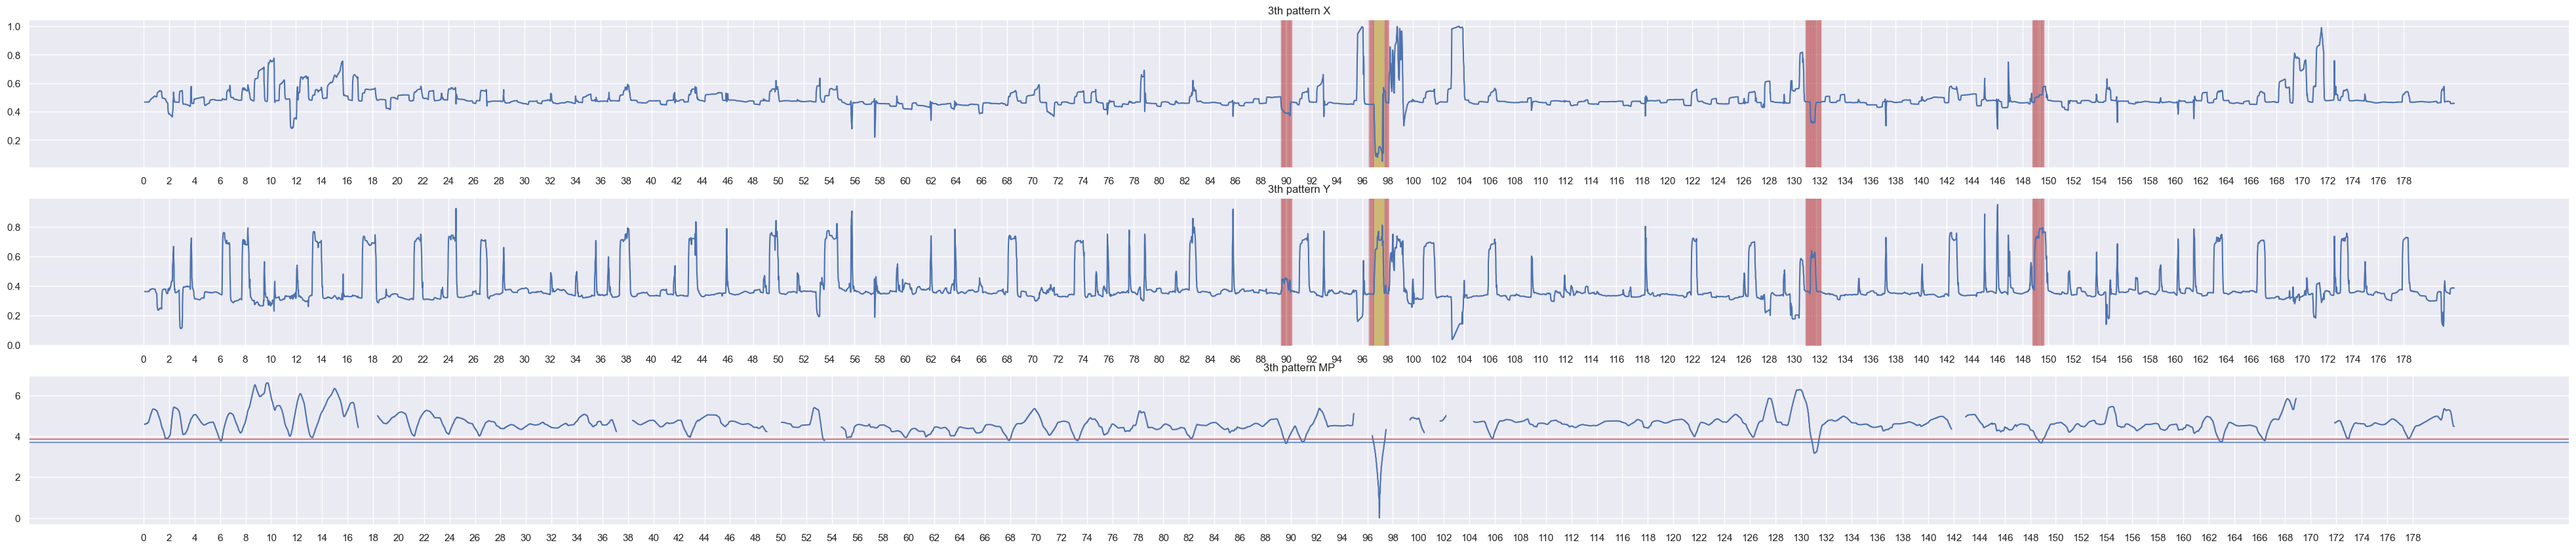

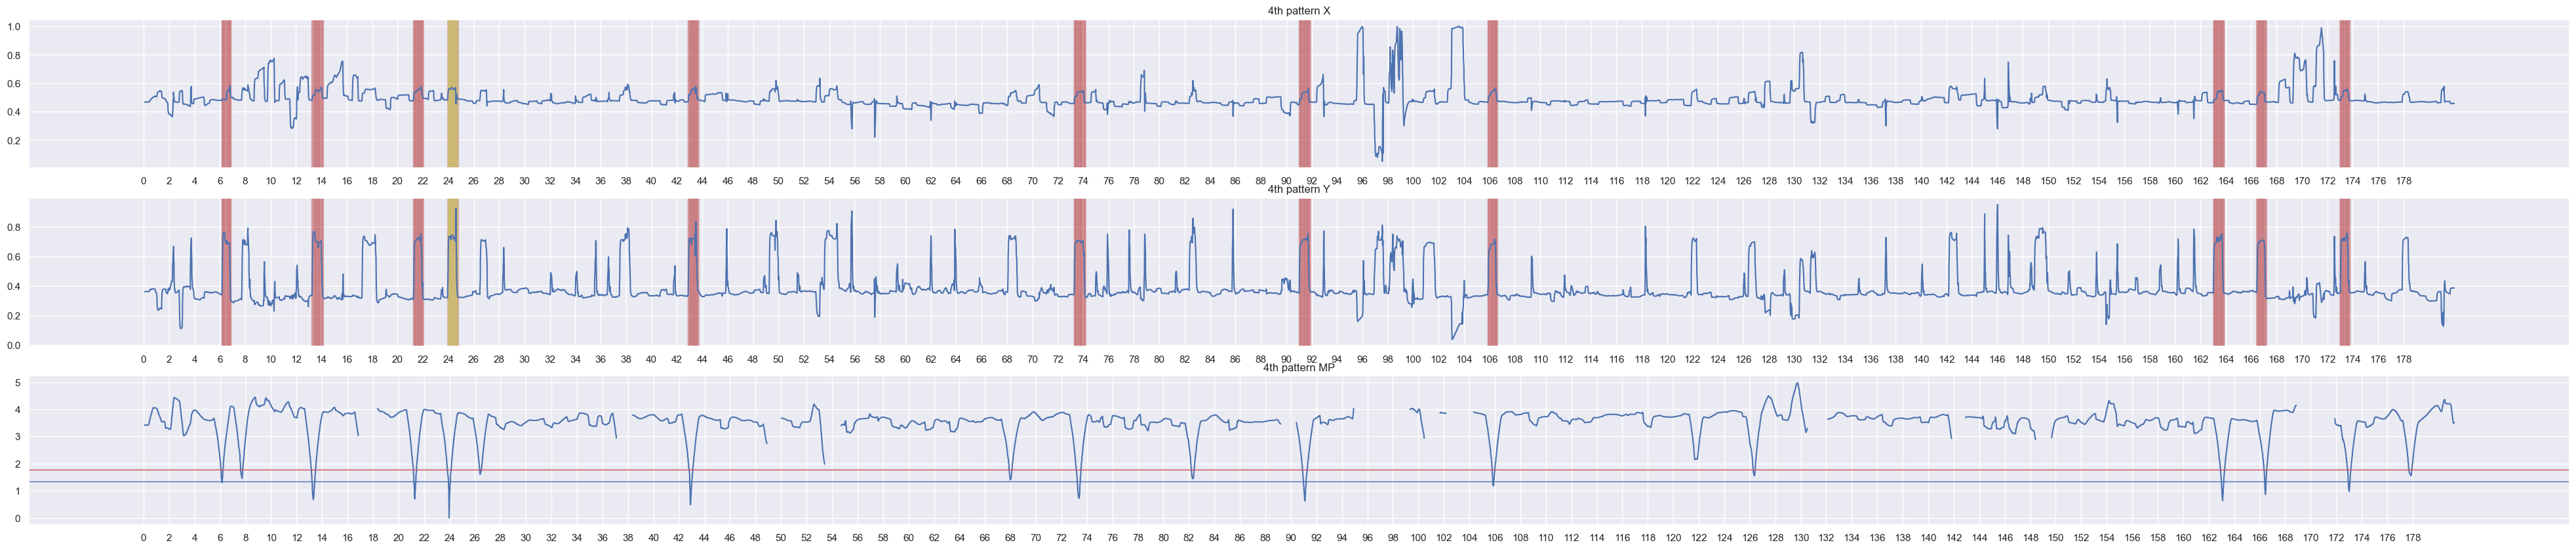

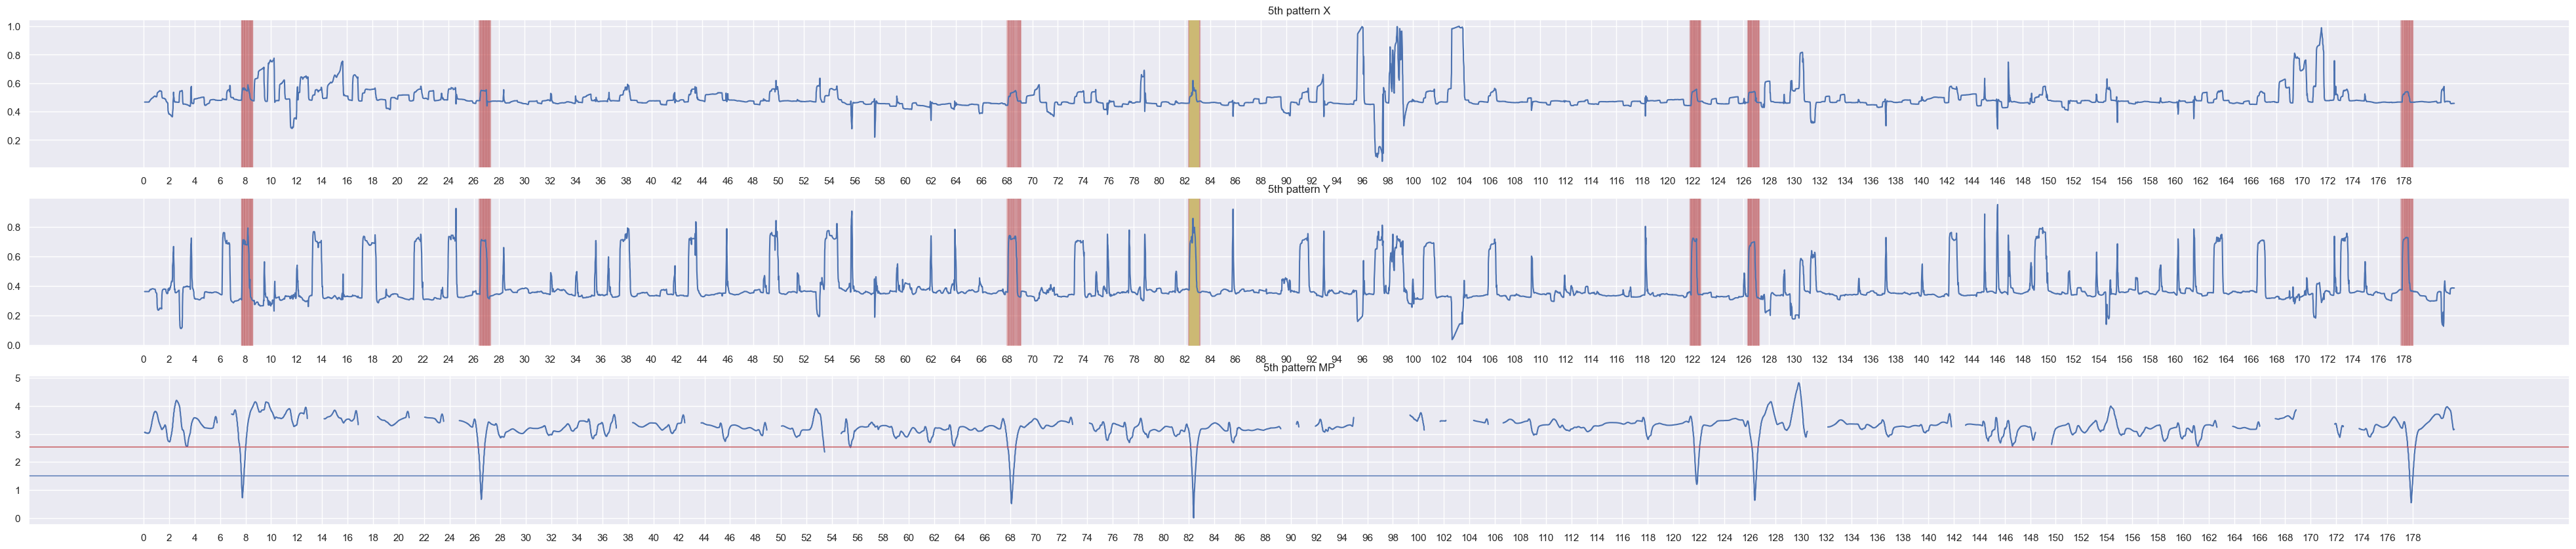

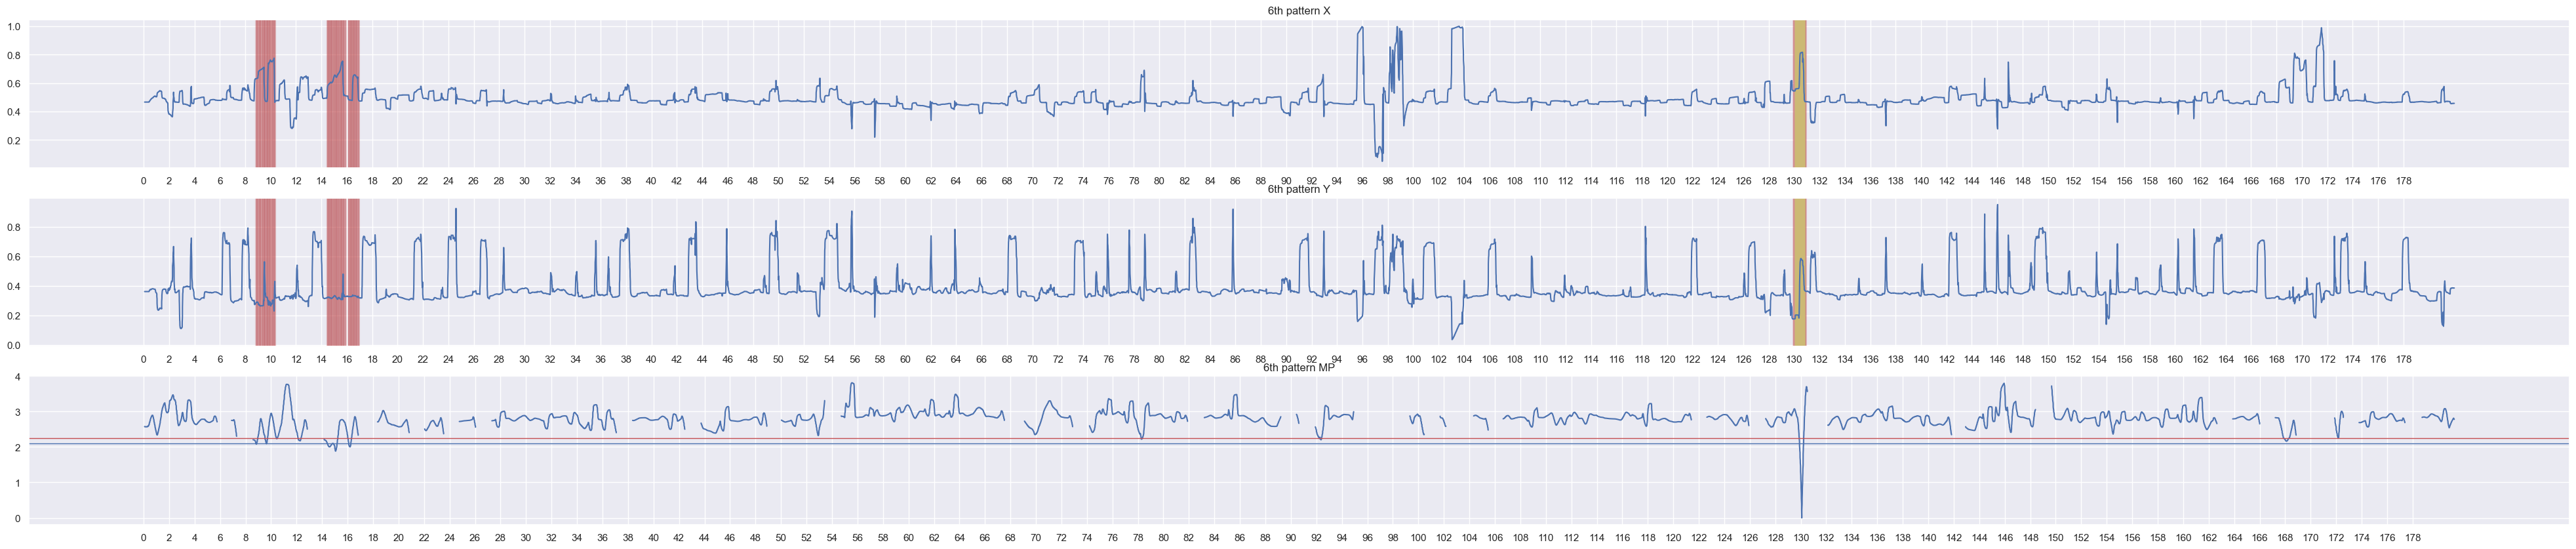

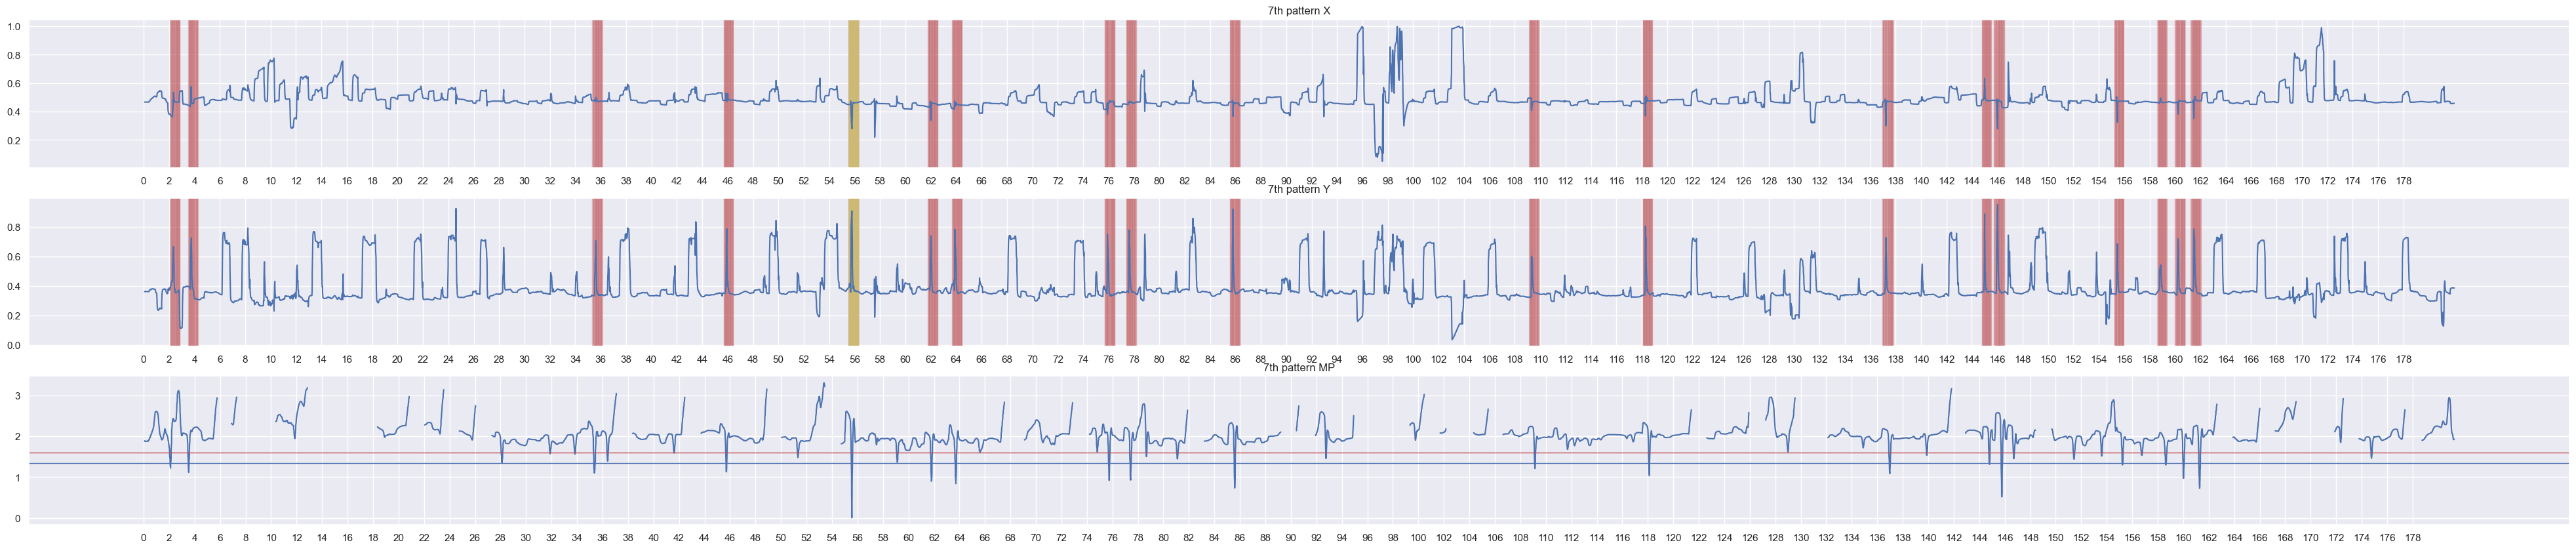

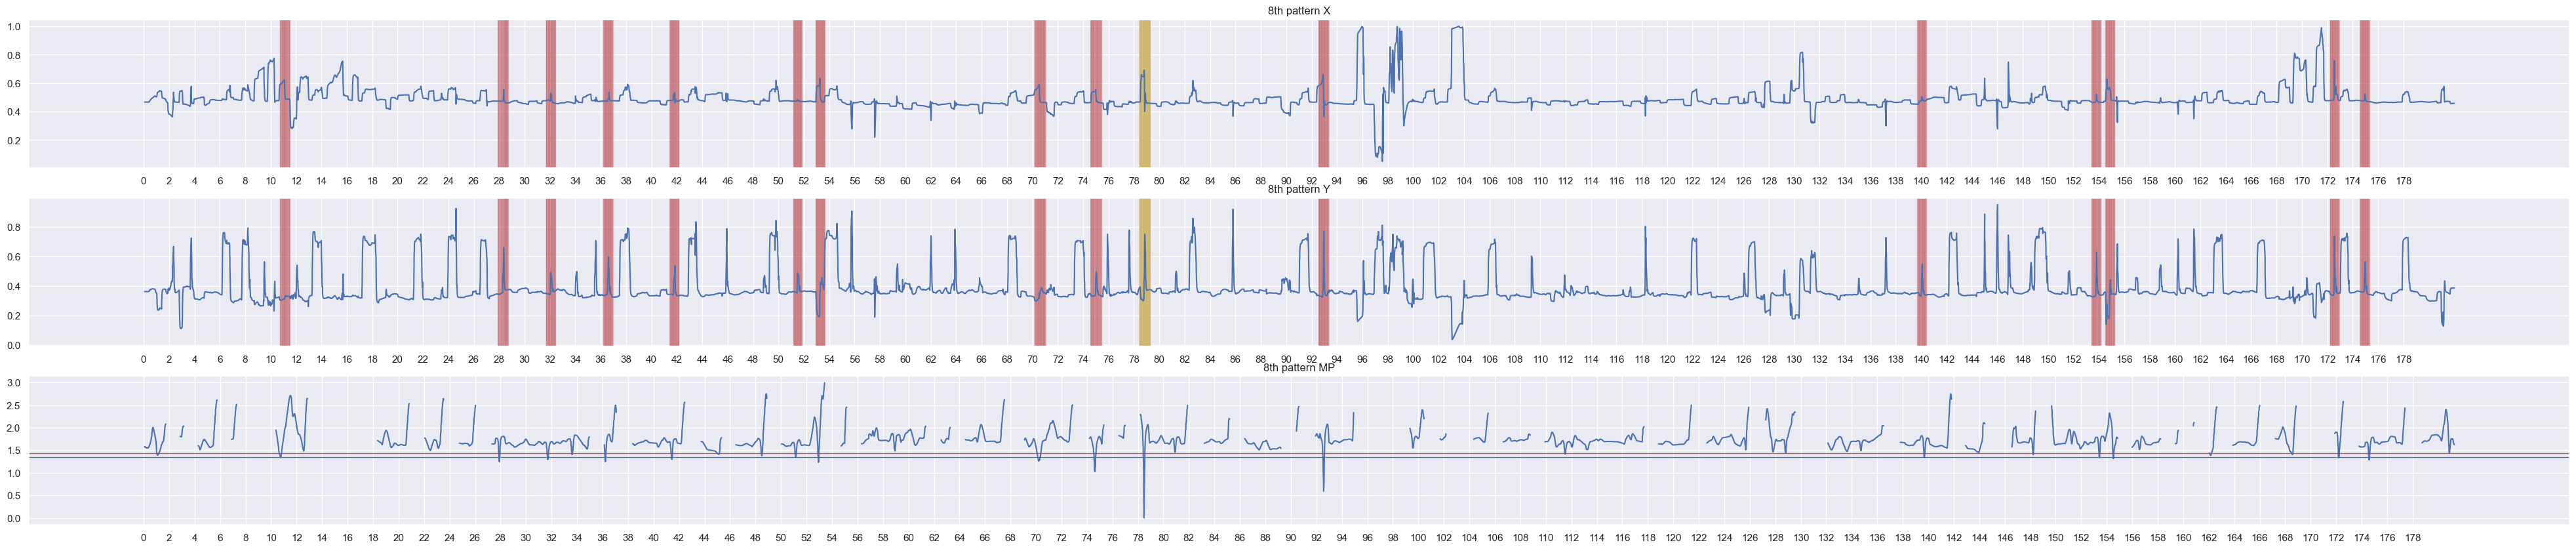

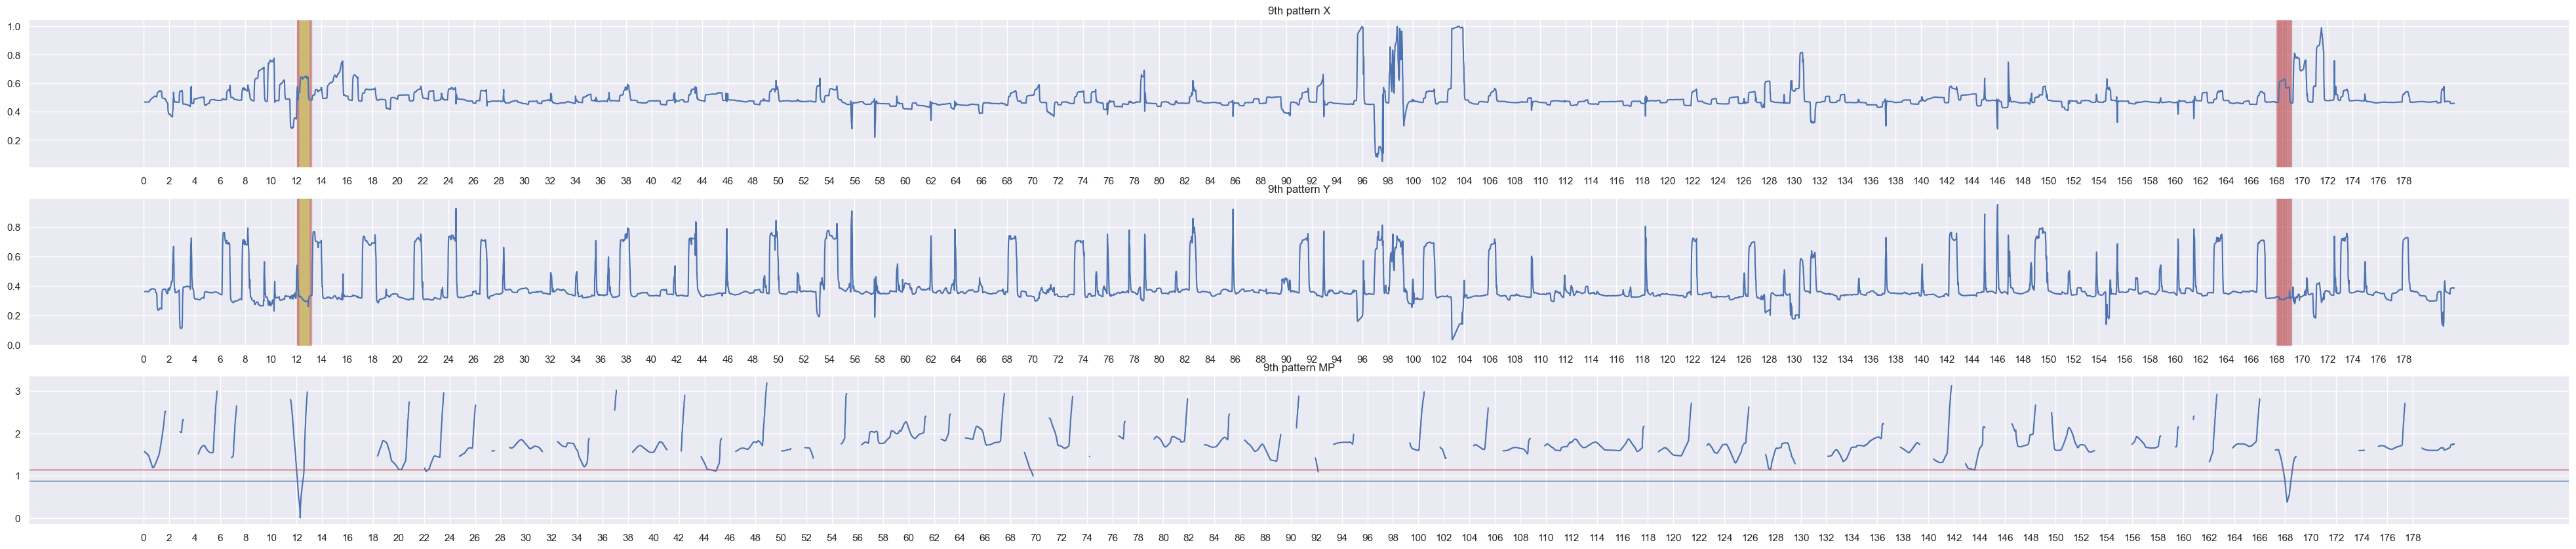

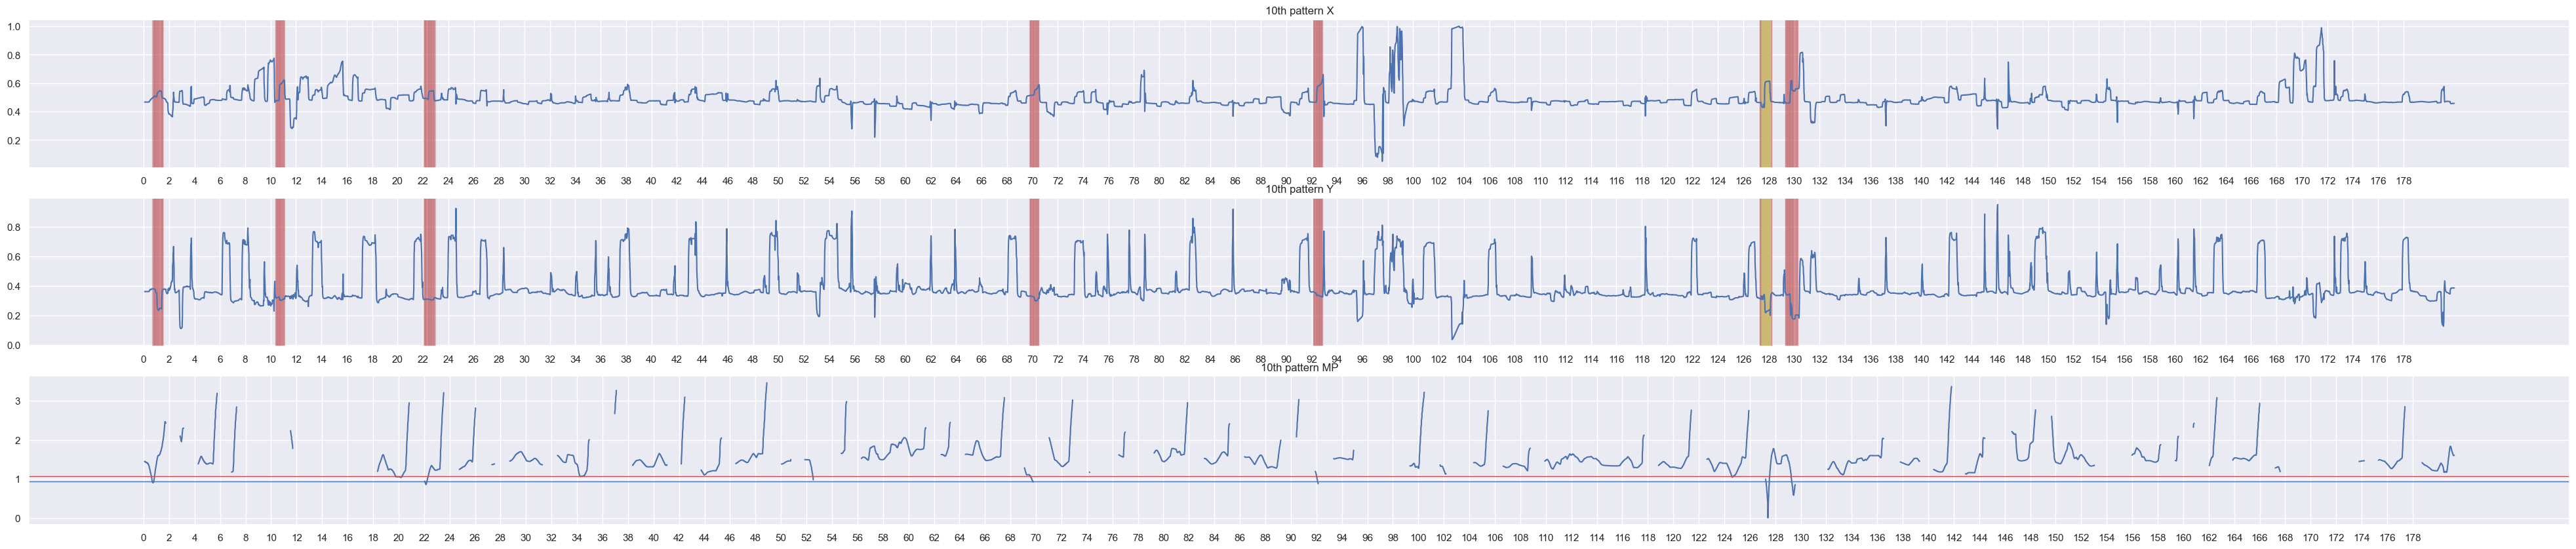

In [12]:
#sns.set(rc={'figure.figsize':(50,50)})
#fig, axs = plt.subplots(k, 2)
for i in range(k):
    # find a pattern whose distance with other sequences are the largest 
    profile_areas = np.nansum(D_plot, axis=1)
    idx = np.where(profile_areas == max(profile_areas[profile_areas<np.inf]))[0][0]
    
    snippets_x[i] = Tx[indices[idx] : indices[idx] + m]
    snippets_y[i] = Ty[indices[idx] : indices[idx] + m]
    snippets_aoi[i] = tempdf['aoi_idx'].iloc[indices[idx] : indices[idx] + m] 

    snippets_indices[i] = indices[idx]
    snippets_profiles[i] = D[idx]
    snippets_areas[i] = np.sum(D[idx])
    mask[indices[idx] : indices[idx] + m] = i
    
    # throughout the sequence, if the MP is below certain point, we assign the pattern
    for maskidx in np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0]:
        mask[(maskidx) : (maskidx + m)] = i
        Tx_process[(maskidx - int(m/2)) : (maskidx + m)] = np.nan # remove Tx of the current pattern so that it does not affect the next pattern selection
        Ty_process[(maskidx - int(m/2)) : (maskidx + m)] = np.nan # remove Ty of the current pattern so that it does not affect the next pattern selection
    
    mask_list.append(np.append(np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0],indices[idx]))
    
    """
    for t in tempdf['rec_time_s'].iloc[np.where(mask==i)[0]]:
        axs[i,0].axvline(t, color='r',ls='-',lw = 1)
        axs[i,1].axvline(t, color='r',ls='-',lw = 1)
    axs[i,0].plot(tempdf['rec_time_s'], Tx)
    axs[i,1].plot(tempdf['rec_time_s'], Ty)
    axs[i,0].set_xticks(np.arange(0,180,2))
    axs[i,1].set_xticks(np.arange(0,180,2))    
    
    """
    sns.set(rc={'figure.figsize':(50,10)})
    fig, axs = plt.subplots(3)
    axs[0].set_title(f'{i+1}th pattern X')
    axs[1].set_title(f'{i+1}th pattern Y')
    axs[2].set_title(f'{i+1}th pattern MP')
    for t in tempdf['rec_time_s'].iloc[np.where(mask==i)[0]]:
        axs[0].axvline(t, color='r',ls='-',lw = 1, alpha = 0.1)
        axs[1].axvline(t, color='r',ls='-',lw = 1, alpha = 0.1)
    for t in tempdf['rec_time_s'].iloc[indices[idx]:(indices[idx]+m)]:
        axs[0].axvline(t, color='y',ls='-',lw = 1)
        axs[1].axvline(t, color='y',ls='-',lw = 1)
    axs[0].plot(tempdf['rec_time_s'], Tx)
    axs[1].plot(tempdf['rec_time_s'], Ty)
    axs[2].plot(tempdf['rec_time_s'].iloc[:-m+1], D_plot[idx,:])
    axs[2].axhline(np.nanquantile(D_plot[idx],0.025), color='r',ls='-',lw = 1)
    axs[2].axhline(np.nanquantile(D_plot[idx],0.010), color='b',ls='-',lw = 1)
    for ax in axs: ax.set_xticks(np.arange(0,180,2))
    plt.show()
    
    # post-processing to avoid situations where a similar pattern is selected in the next step
    D_plot[np.array([np.max(mask[index:index+m])>=0 for index in indices]),:] = np.nan
    D_plot[:,np.isnan(Tx_process[:-m+1])] = np.nan
    D_plot[np.where(np.abs(indices - indices[idx])<int(m/2))[0],:] = np.nan
plt.show()

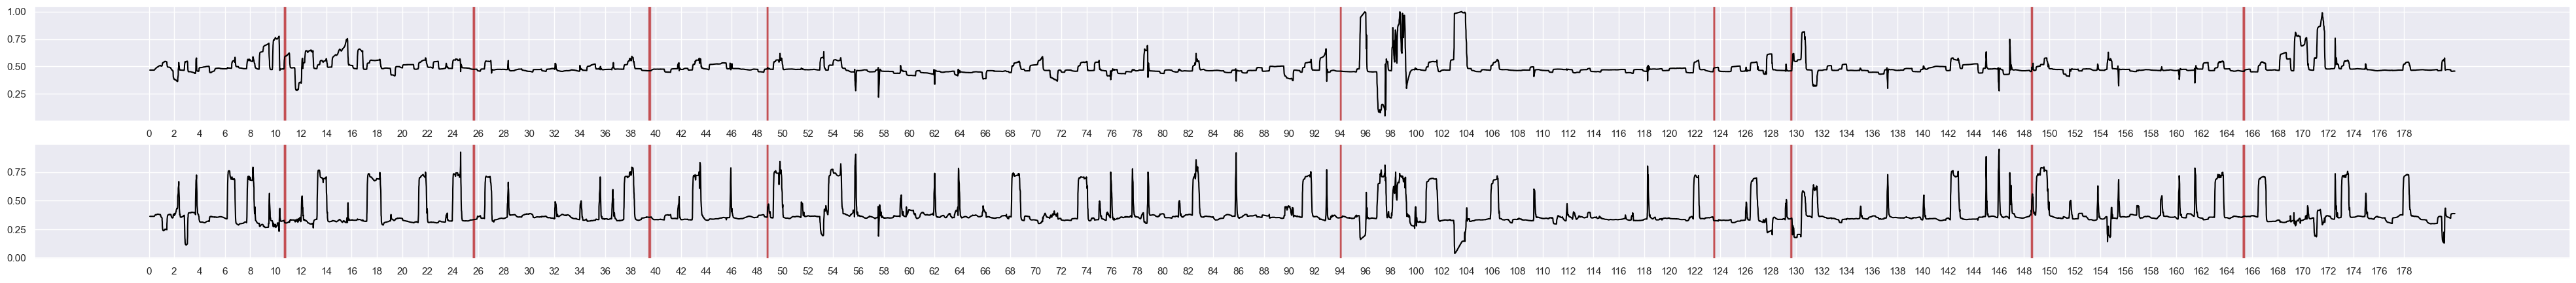

In [13]:
# X positions with speed signs
signxs = np.array([[70,350,625,825,1925,2625,2750,3125,3450]])   
dist = np.abs(np.array(tempdf[['Simulator_XPosition']]) - signxs)
min_dist = np.min(dist, axis=1)
signwhere = np.where(min_dist<=1)[0] 

sns.set(rc={'figure.figsize':(50,5)})
fig, axs = plt.subplots(2, 1)
for t in signwhere:
    axs[0].axvline(tempdf['rec_time_s'].iloc[t], color='r',ls='-',lw = 1, alpha = 0.5)
    axs[1].axvline(tempdf['rec_time_s'].iloc[t], color='r',ls='-',lw = 1, alpha = 0.5)
axs[0].plot(tempdf['rec_time_s'], Tx, color = 'black')
axs[1].plot(tempdf['rec_time_s'], Ty, color = 'black')
for ax in axs: ax.set_xticks(np.arange(0,180,2))
plt.show()

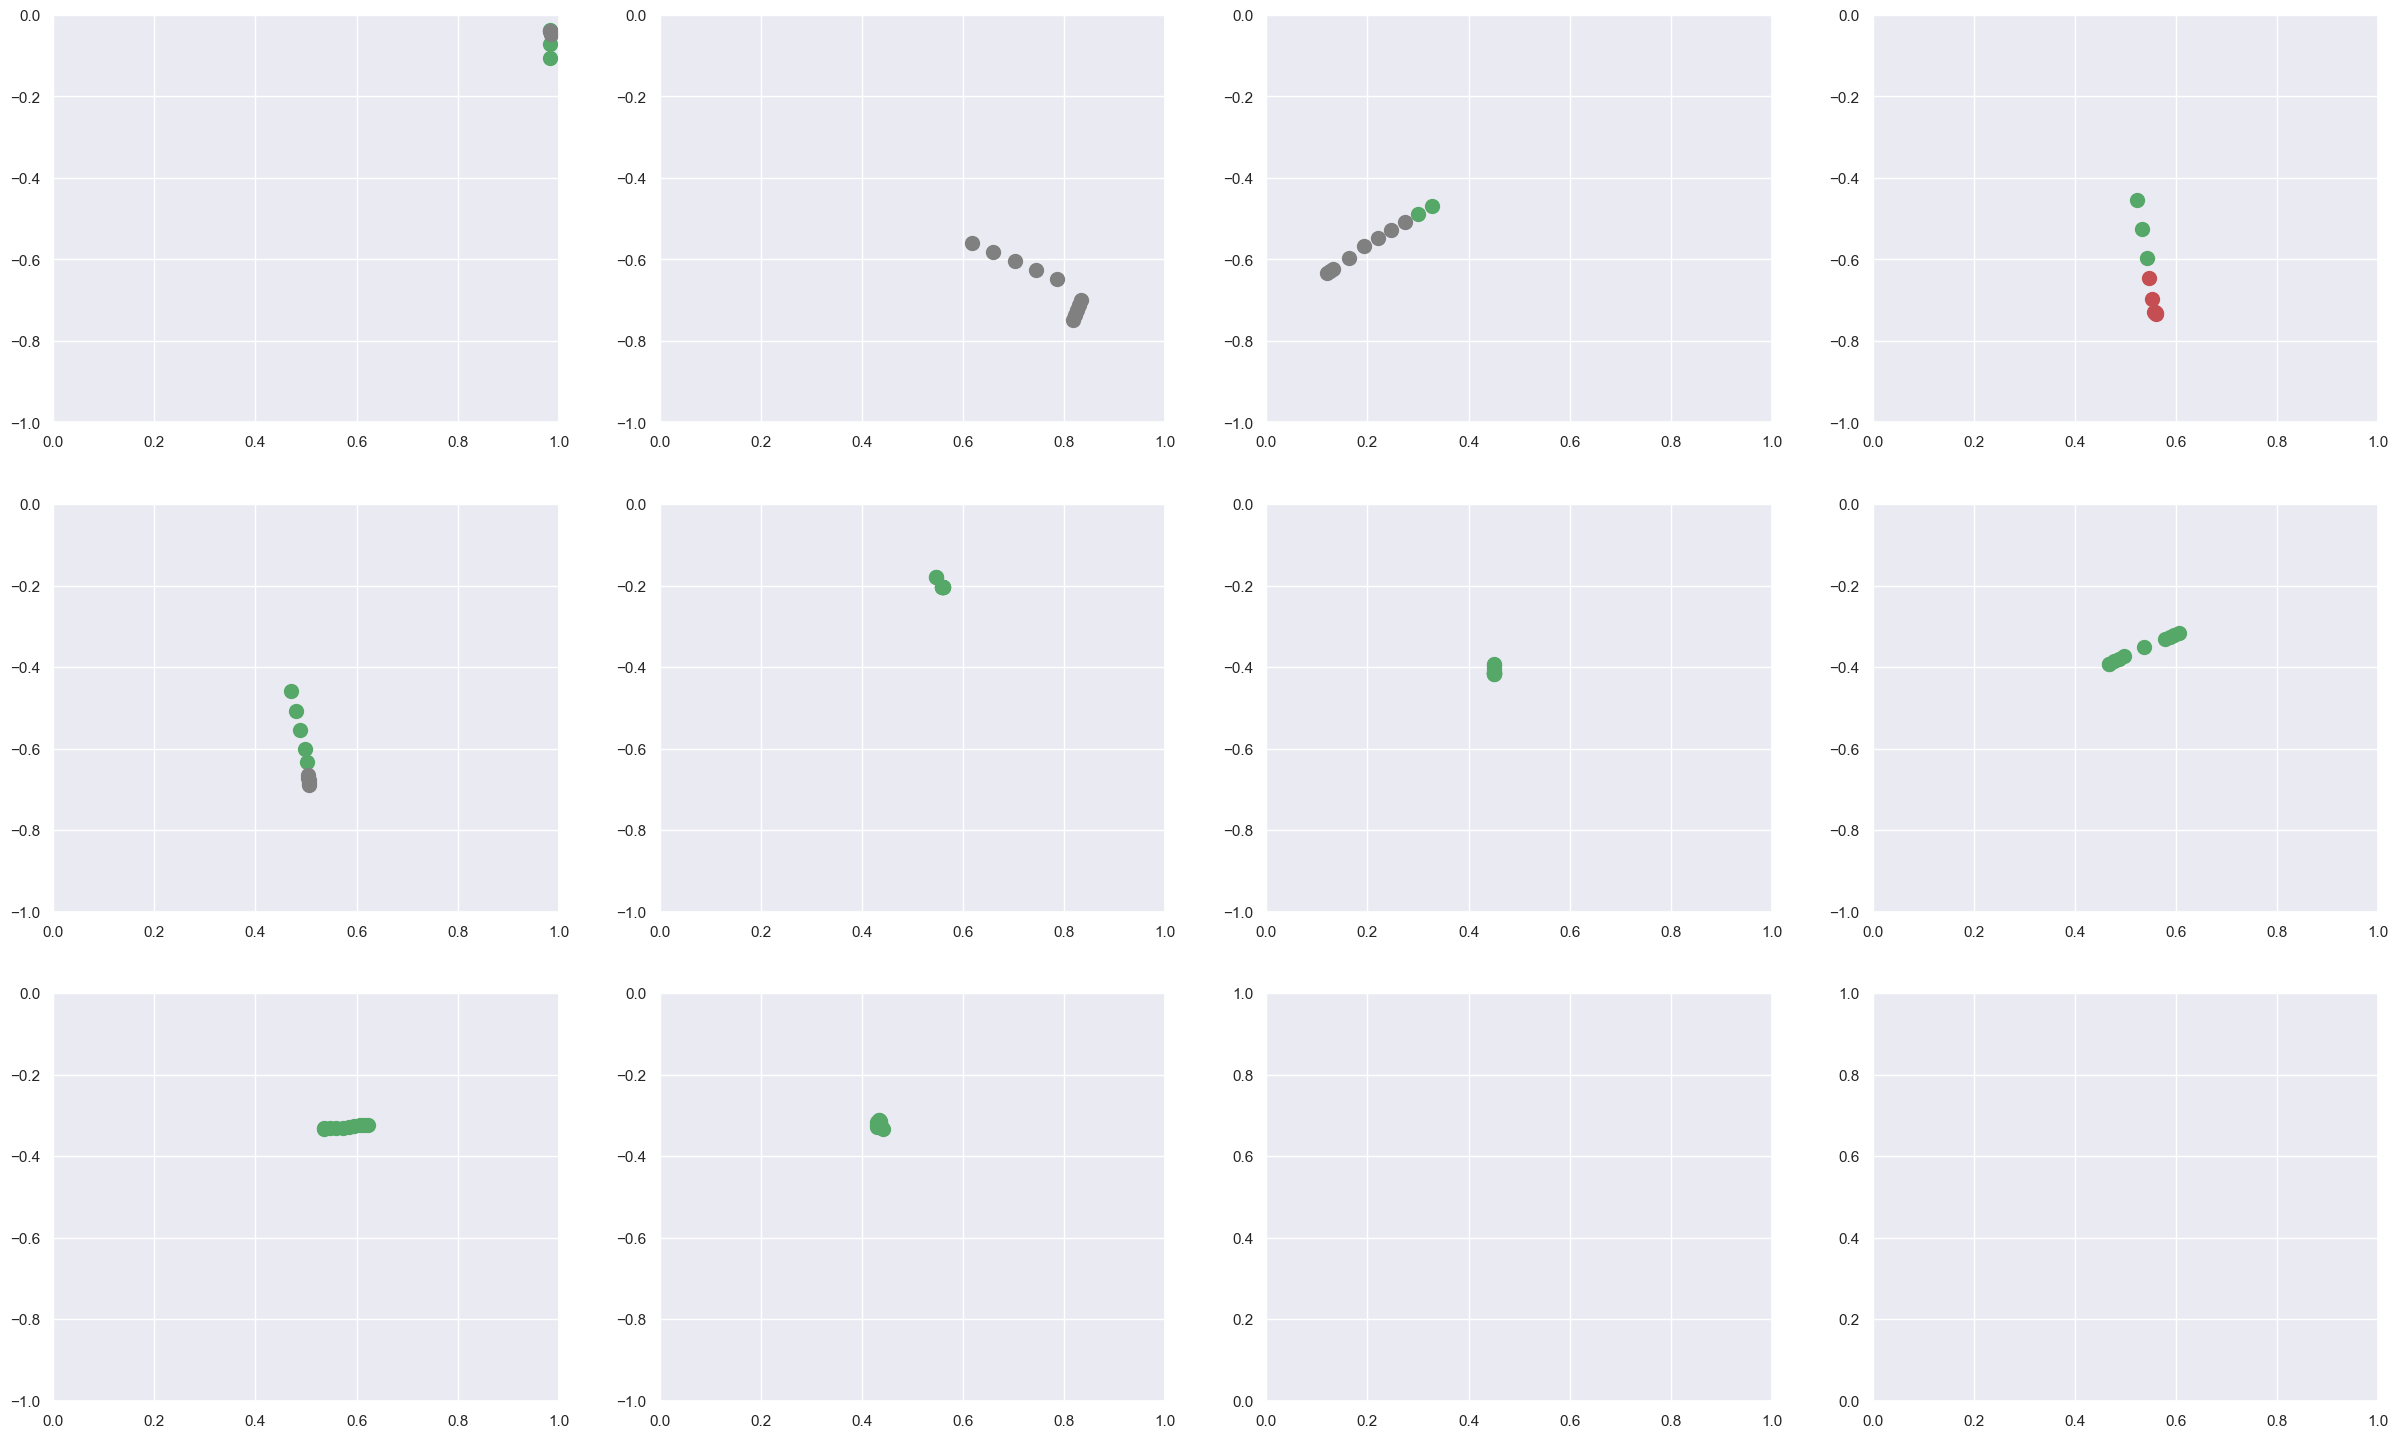

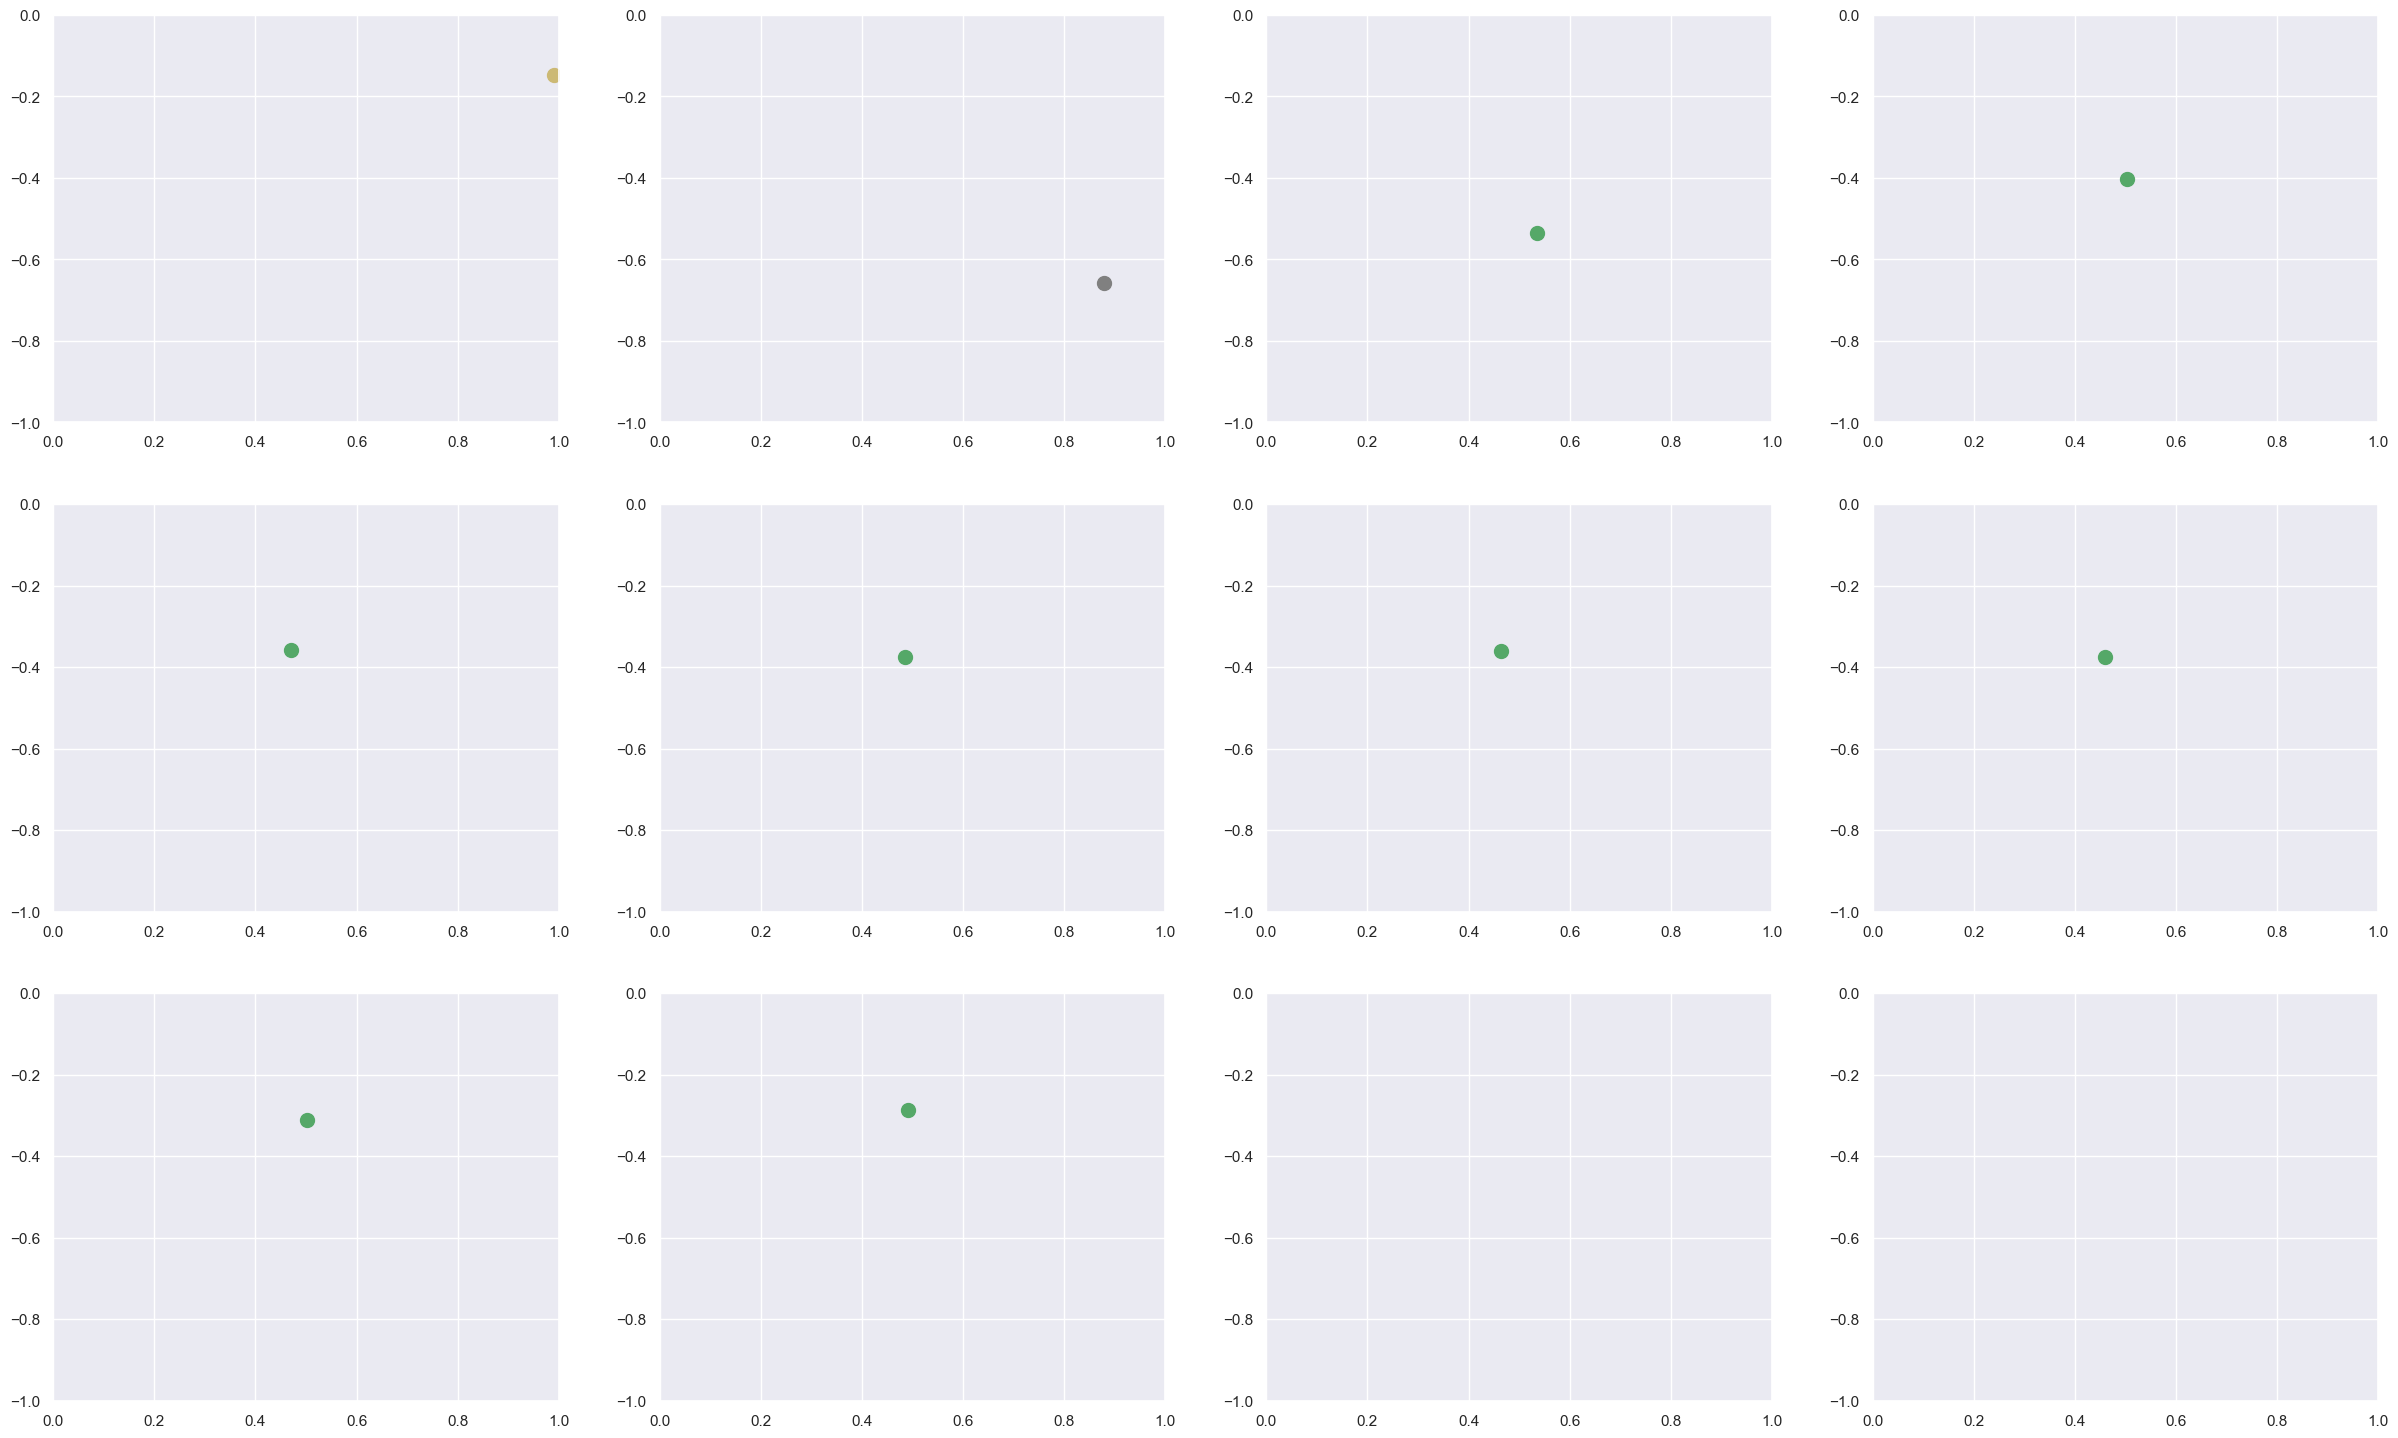

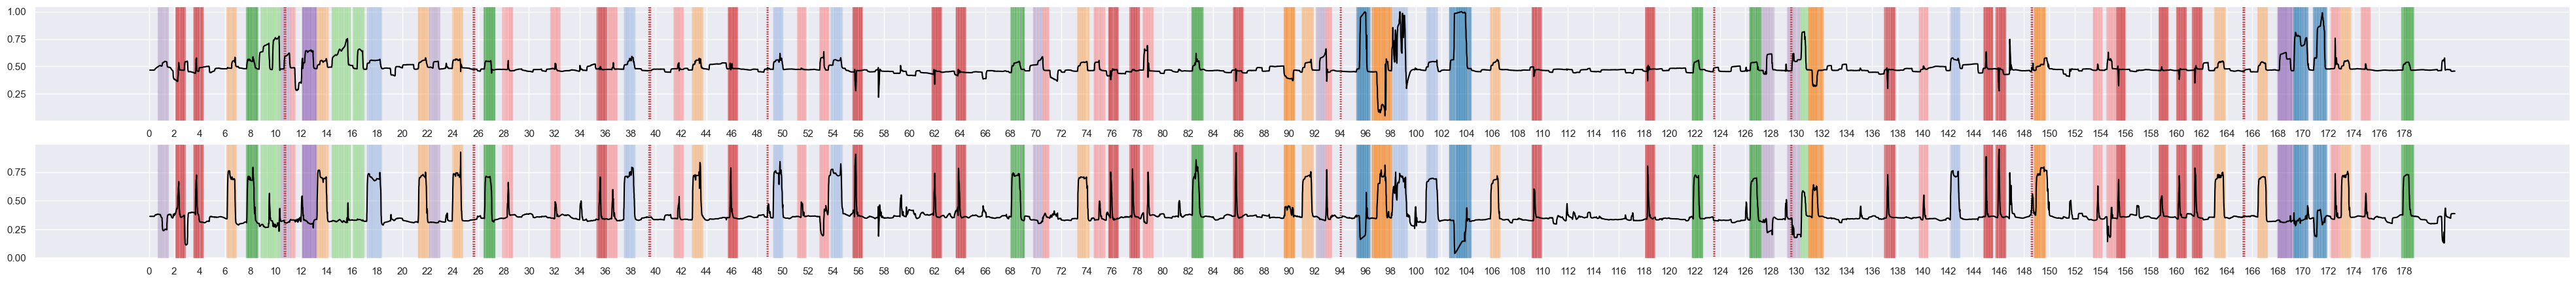

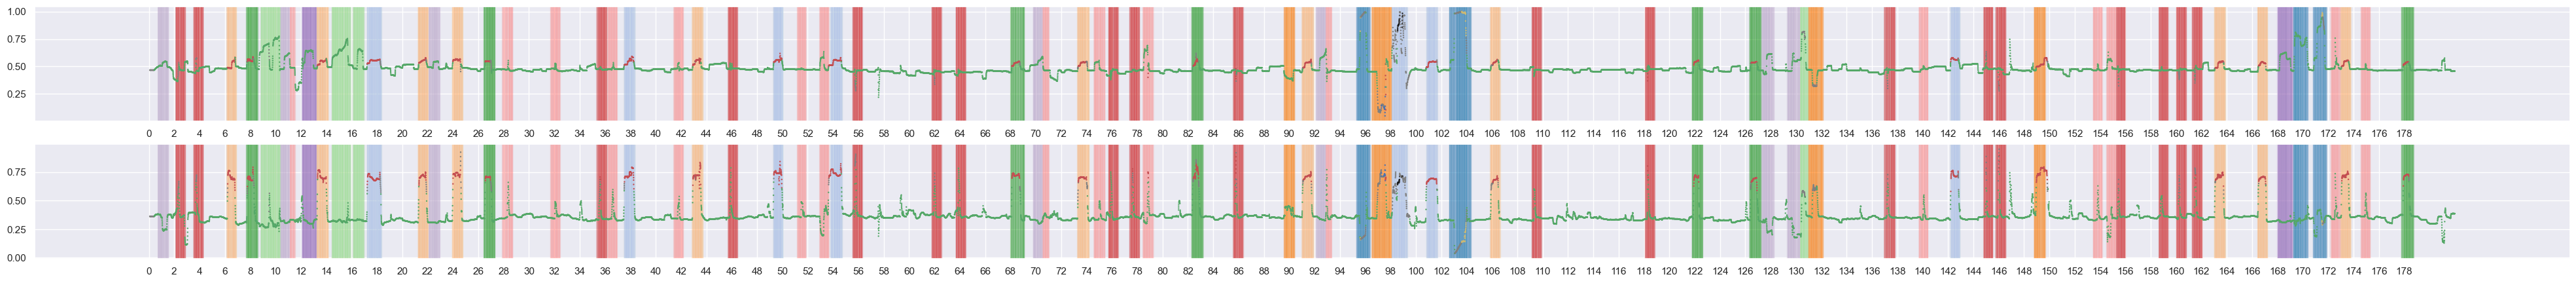

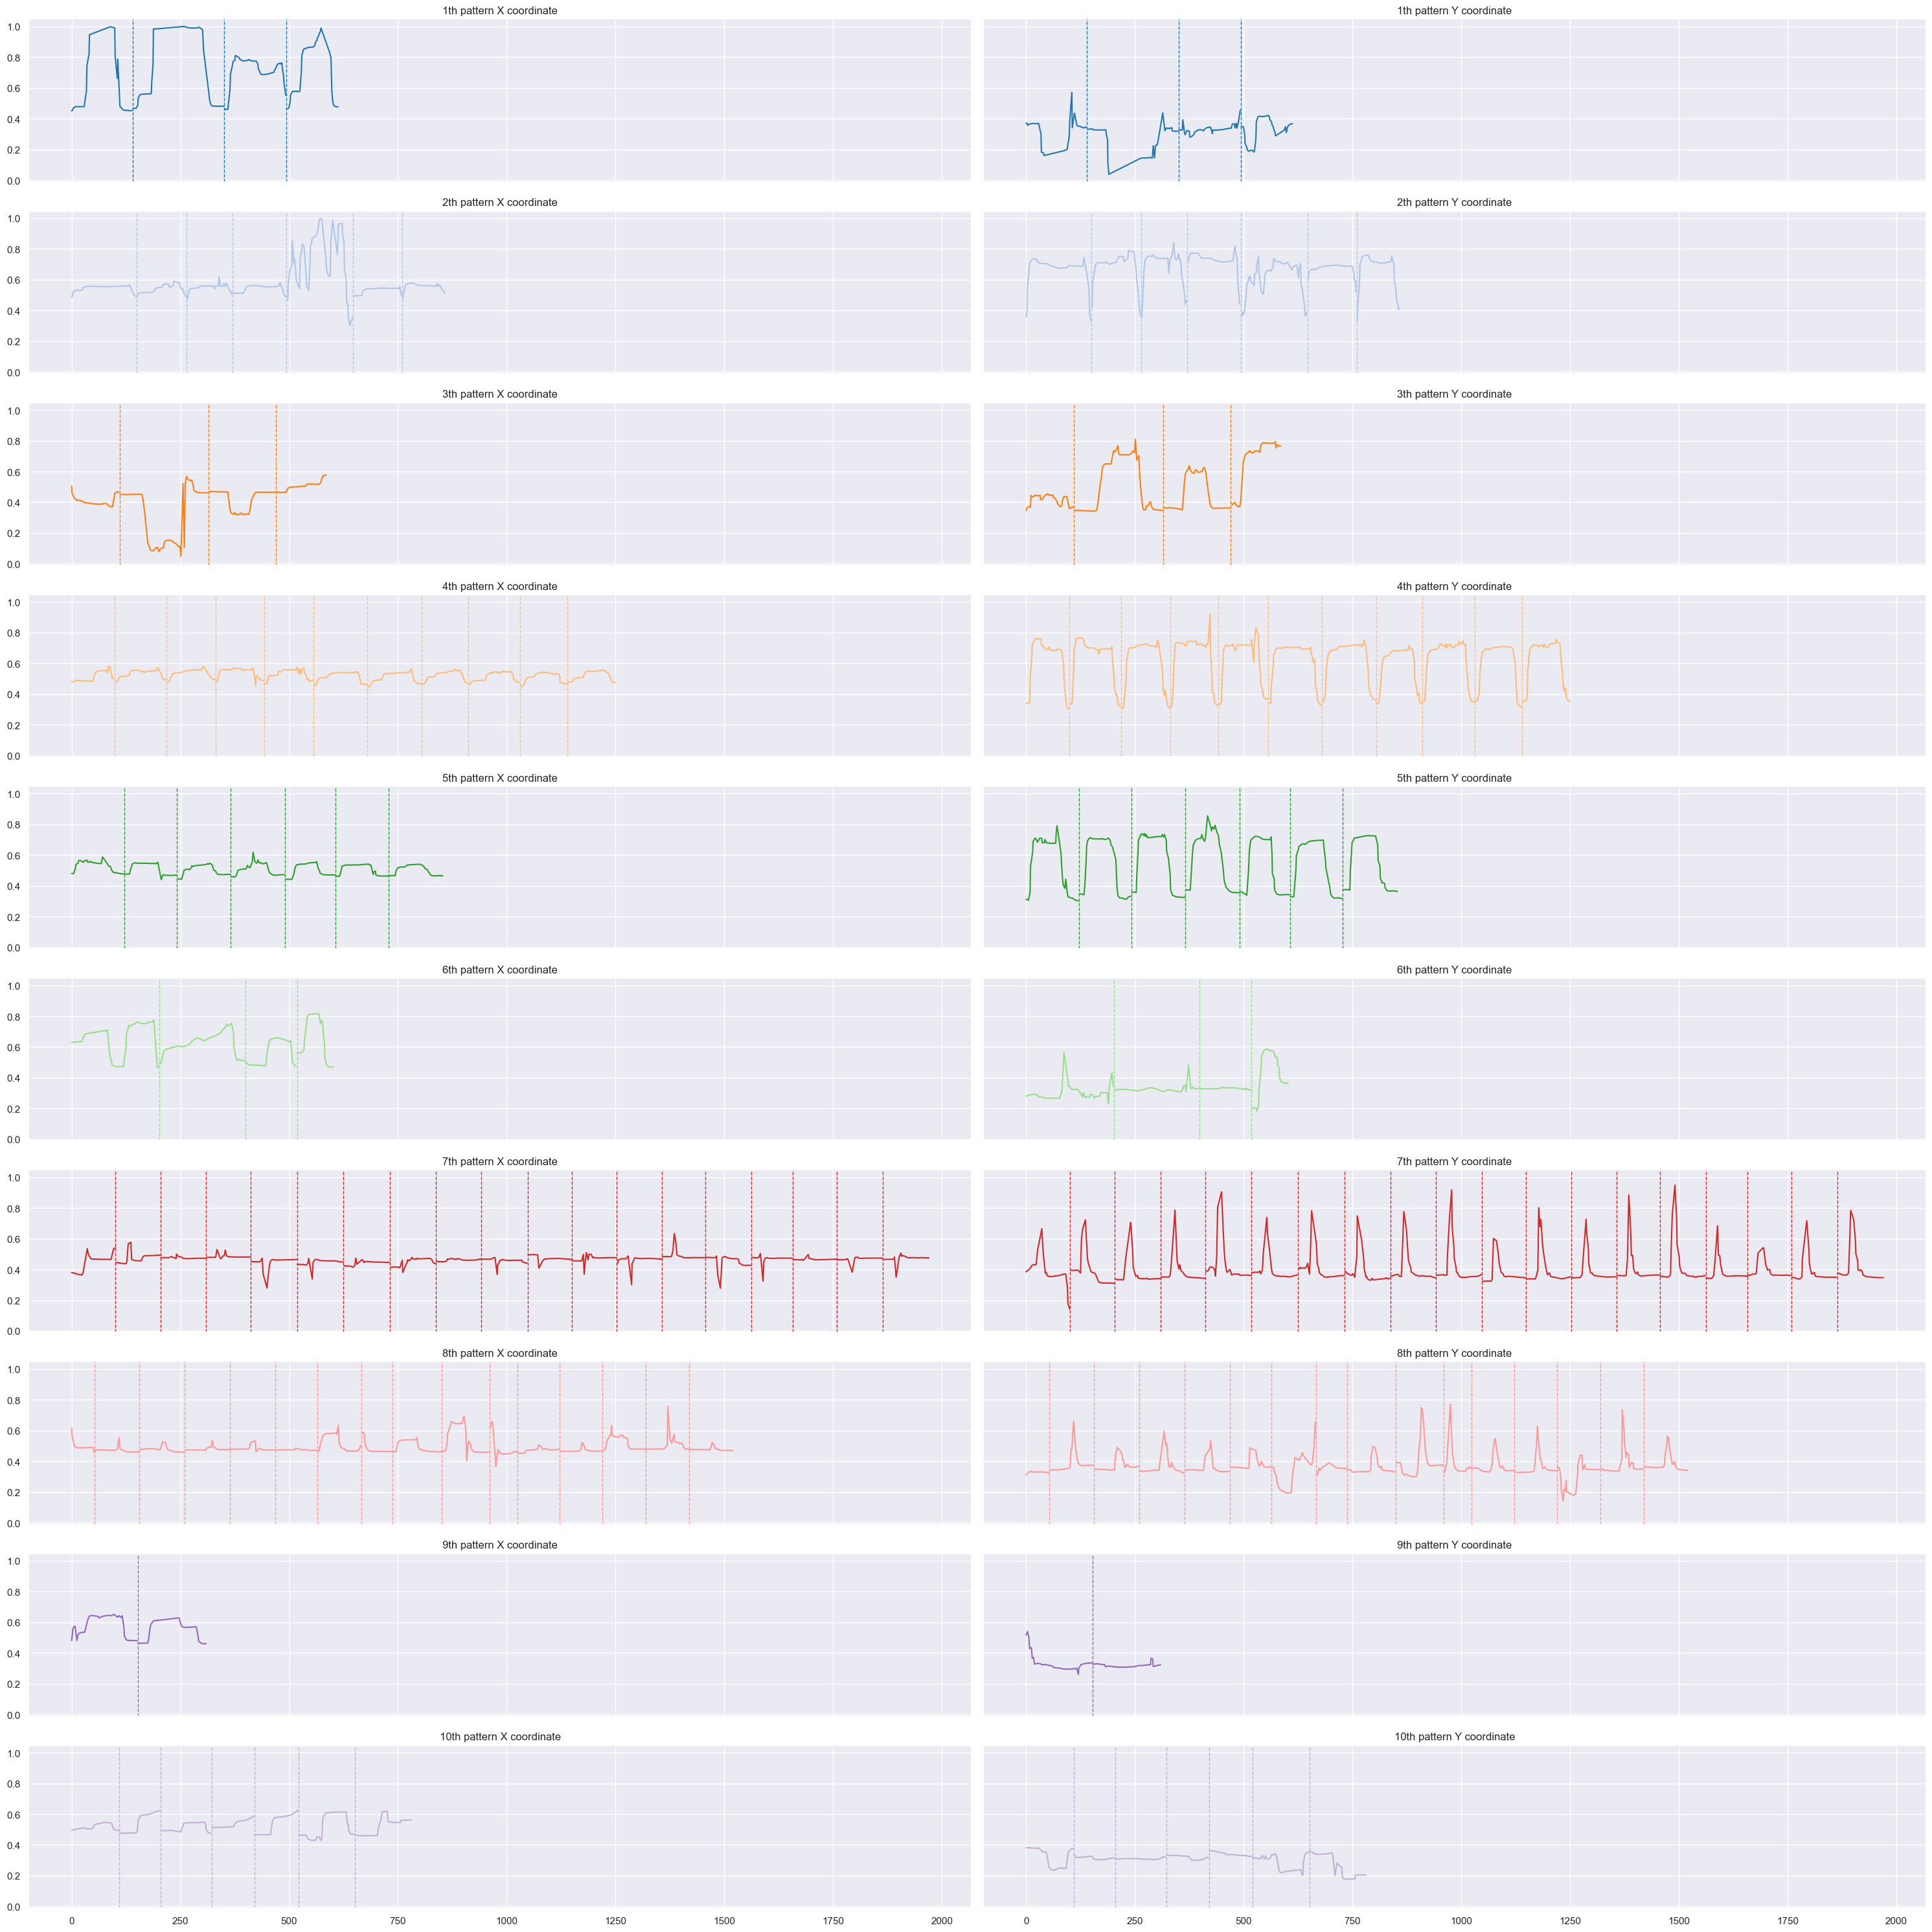

In [14]:
# Visualization of k patterns
aoi_dict = {'AOI.Invalid':'grey','Rearview.Mirror.1':'y','Dashboard.1':'r', 'Front.Shield.1':'g', 'Left.Side.Mirror.1':'b', 'Right.Side.Mirror.1':'k'}

sns.set(rc={'figure.figsize':(30,18)})
fig, axs = plt.subplots(3,4)
for i in range(k):
    for t in range(snippets_aoi.shape[0]):
        axs.flat[i].plot(snippets_x[i,t],-snippets_y[i,t], 'o', color=aoi_dict[snippets_aoi[i,t]], markersize=10)#sns.color_palette("tab20")[i])
    axs.flat[i].set_xlim([0,1])
    axs.flat[i].set_ylim([-1,0])
plt.show()

sns.set(rc={'figure.figsize':(30,18)})
snippets_yl = (-snippets_y).tolist()
snippets_xl = snippets_x.tolist()
fig, axs = plt.subplots(3, 4)
for ax in axs.flat:
    ax.set_xlim([0,1])
    ax.set_ylim([-1,0])
lines = [ax.plot(x[0], y[0], 'o', color=aoi_dict[aoi[0]], markersize=10)[0] for ax, x, y, aoi in zip(axs.flat, snippets_xl, snippets_yl, snippets_aoi)]
def update(frame):
    for line, x, y, aoi in zip(lines, snippets_xl, snippets_yl, snippets_aoi):
        line.set_xdata(x[frame])
        line.set_ydata(y[frame])
        line.set_color(aoi_dict[aoi[frame]])
    return lines
ani = animation.FuncAnimation(fig, update, frames=np.arange(m), blit=True)
ani.save('extracted_patterns.mp4', writer=animation.FFMpegWriter(fps=20))


sns.set(rc={'figure.figsize':(50,5)})
fig, axs = plt.subplots(2)
for i in range(k):
    for t in tempdf['rec_time_s'].iloc[np.where(mask==i)[0]]:
        axs[0].axvline(t, color=sns.color_palette("tab20")[i],ls='-',lw = 1, alpha = 0.1)
        axs[1].axvline(t, color=sns.color_palette("tab20")[i],ls='-',lw = 1, alpha = 0.1)
for t in signwhere:
    axs[0].axvline(tempdf['rec_time_s'].iloc[t], color='r',ls=':',lw = 1, alpha = 1)
    axs[1].axvline(tempdf['rec_time_s'].iloc[t], color='r',ls=':',lw = 1, alpha = 1)
axs[0].plot(tempdf['rec_time_s'], Tx, color = 'black')
axs[1].plot(tempdf['rec_time_s'], Ty, color = 'black')
axs[0].set_xticks(np.arange(0,180,2))
axs[1].set_xticks(np.arange(0,180,2))
plt.show()

sns.set(rc={'figure.figsize':(50,5)})
fig, axs = plt.subplots(2)
for i in range(k):
    for t in tempdf['rec_time_s'].iloc[np.where(mask==i)[0]]:
        axs[0].axvline(t, color=sns.color_palette("tab20")[i],ls='-',lw = 1, alpha = 0.1, zorder=1)
        axs[1].axvline(t, color=sns.color_palette("tab20")[i],ls='-',lw = 1, alpha = 0.1, zorder=1)
axs[0].scatter(tempdf['rec_time_s'], Tx, color = [aoi_dict[key] for key in tempdf['aoi_idx']], s = 0.5, zorder=2)
axs[1].scatter(tempdf['rec_time_s'], Ty, color = [aoi_dict[key] for key in tempdf['aoi_idx']], s = 0.5, zorder=2)
axs[0].set_xticks(np.arange(0,180,2))
axs[1].set_xticks(np.arange(0,180,2))
plt.show()

sns.set(rc={'figure.figsize':(30,30)})
fig, axs = plt.subplots(k,2, sharey = True, sharex = True)
for i in range(k):
    t = np.array(tempdf['rec_time_s'].iloc[np.where(mask==i)[0]])
    ta = np.insert(t, np.array(np.where(t[1:]-t[:-1]>0.1)[0])+1, np.nan)
    Ttx = Tx[np.where(mask==i)[0]]
    Ttx = np.insert(Ttx, np.array(np.where(t[1:]-t[:-1]>0.1)[0])+1, np.nan)
    Tty = Ty[np.where(mask==i)[0]]
    Tty = np.insert(Tty, np.array(np.where(t[1:]-t[:-1]>0.1)[0])+1, np.nan)
    
    axs[i,0].set_title(f'{i+1}th pattern X coordinate')
    axs[i,1].set_title(f'{i+1}th pattern Y coordinate')
    axs[i,0].plot(Ttx, color=sns.color_palette("tab20")[i])
    axs[i,1].plot(Tty, color=sns.color_palette("tab20")[i])
    for nanloc in np.array(np.where(np.isnan(Ttx))[0]):
        axs[i,0].axvline(nanloc, color=sns.color_palette("tab20")[i],ls='--',lw = 1)
        axs[i,1].axvline(nanloc, color=sns.color_palette("tab20")[i],ls='--',lw = 1)
plt.tight_layout()
plt.show()

/Users/maxingjian/opt/anaconda3/lib/python3.9/site-packages/tslearn/metrics/dtw_variants.py:1066: RuntimeWarning: 'itakura_max_slope' constraint is unfeasible (ie. leads to no admissible path) for the provided time series sizes
  warnings.warn("'itakura_max_slope' constraint is unfeasible "
/Users/maxingjian/opt/anaconda3/lib/python3.9/site-packages/tslearn/metrics/dtw_variants.py:1066: RuntimeWarning: 'itakura_max_slope' constraint is unfeasible (ie. leads to no admissible path) for the provided time series sizes
  warnings.warn("'itakura_max_slope' constraint is unfeasible "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


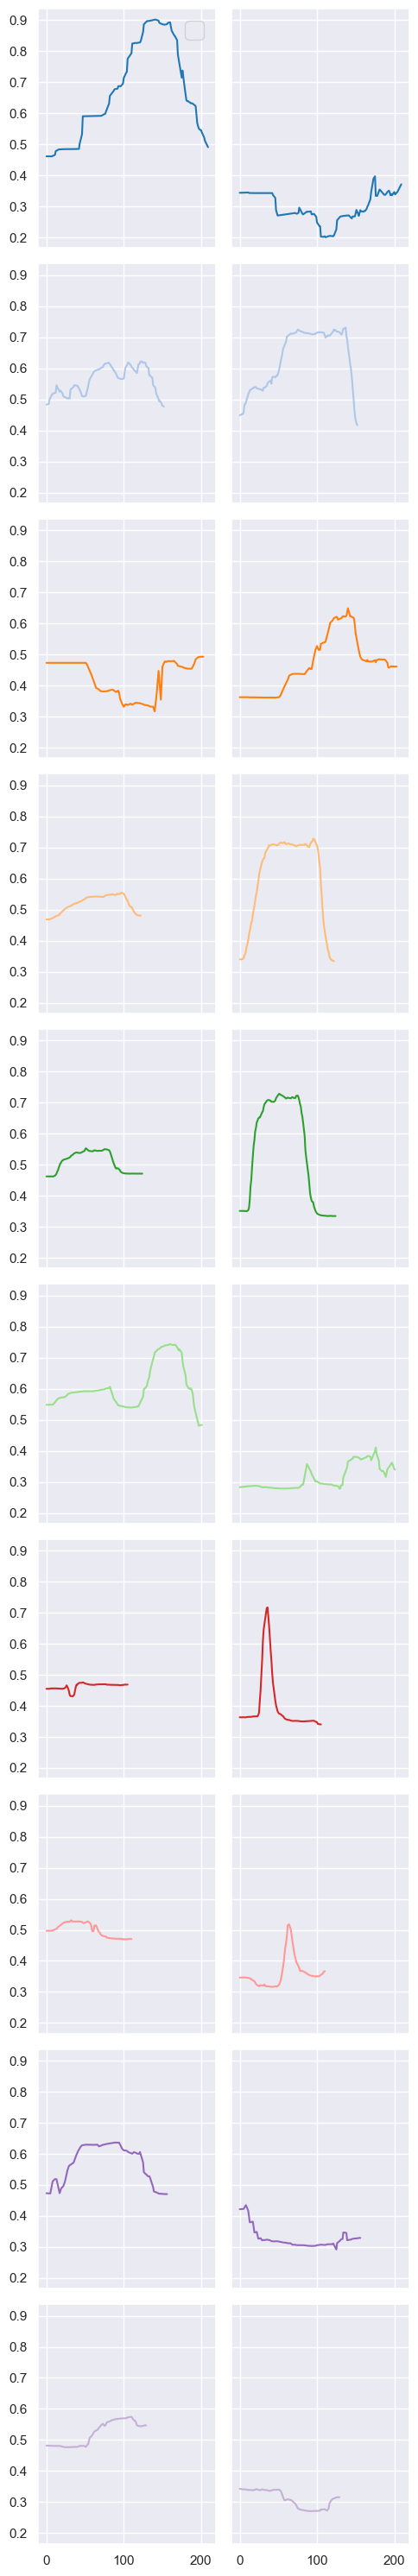

In [15]:
# Average of each pattern using DTW
snippet_xavg = []
snippet_yavg = []
sns.set(rc={'figure.figsize':(5,30)})
fig, axs = plt.subplots(k,2, sharey = True, sharex = True)
for i in range(k):
    t = np.array(tempdf['rec_time_s'].iloc[np.where(mask==i)[0]])
    ta = np.split(t, np.array(np.where(t[1:]-t[:-1]>0.05)[0])+1)
    Ttx = Tx[np.where(mask==i)[0]]
    Ttx = np.split(Ttx, np.array(np.where(t[1:]-t[:-1]>0.05)[0])+1)
    Tty = Ty[np.where(mask==i)[0]]
    Tty = np.split(Tty, np.array(np.where(t[1:]-t[:-1]>0.05)[0])+1)
    
    # We use DTW to calculate the average since two subsequences' lengths may vary even for same pattern
    ref_series = max(Ttx, key=len)
    aligned_series = []
    for s in Ttx:
        optimal_path, dtw_score = dtw_path(ref_series,s,itakura_max_slope = 1)
        aligned_series.append(s[np.array(optimal_path)[:,1]])
    Ttx = np.mean(aligned_series, axis=0)
    snippet_xavg.append(Ttx)
    
    ref_series = max(Tty, key=len)
    aligned_series = []
    for s in Tty:
        optimal_path, dtw_score = dtw_path(ref_series,s,itakura_max_slope = 1)
        aligned_series.append(s[np.array(optimal_path)[:,1]])
    Tty = np.mean(aligned_series, axis=0)
    snippet_yavg.append(Tty)
    
    axs[i,0].plot(Ttx, color=sns.color_palette("tab20")[i])
    axs[i,1].plot(Tty, color=sns.color_palette("tab20")[i])
    for nanloc in np.array(np.where(np.isnan(Ttx))[0]):
        axs[i,0].axvline(nanloc, color=sns.color_palette("tab20")[i],ls='--',lw = 1)
        axs[i,1].axvline(nanloc, color=sns.color_palette("tab20")[i],ls='--',lw = 1)
axs[0,0].legend(fontsize=20)
plt.tight_layout()
plt.show()

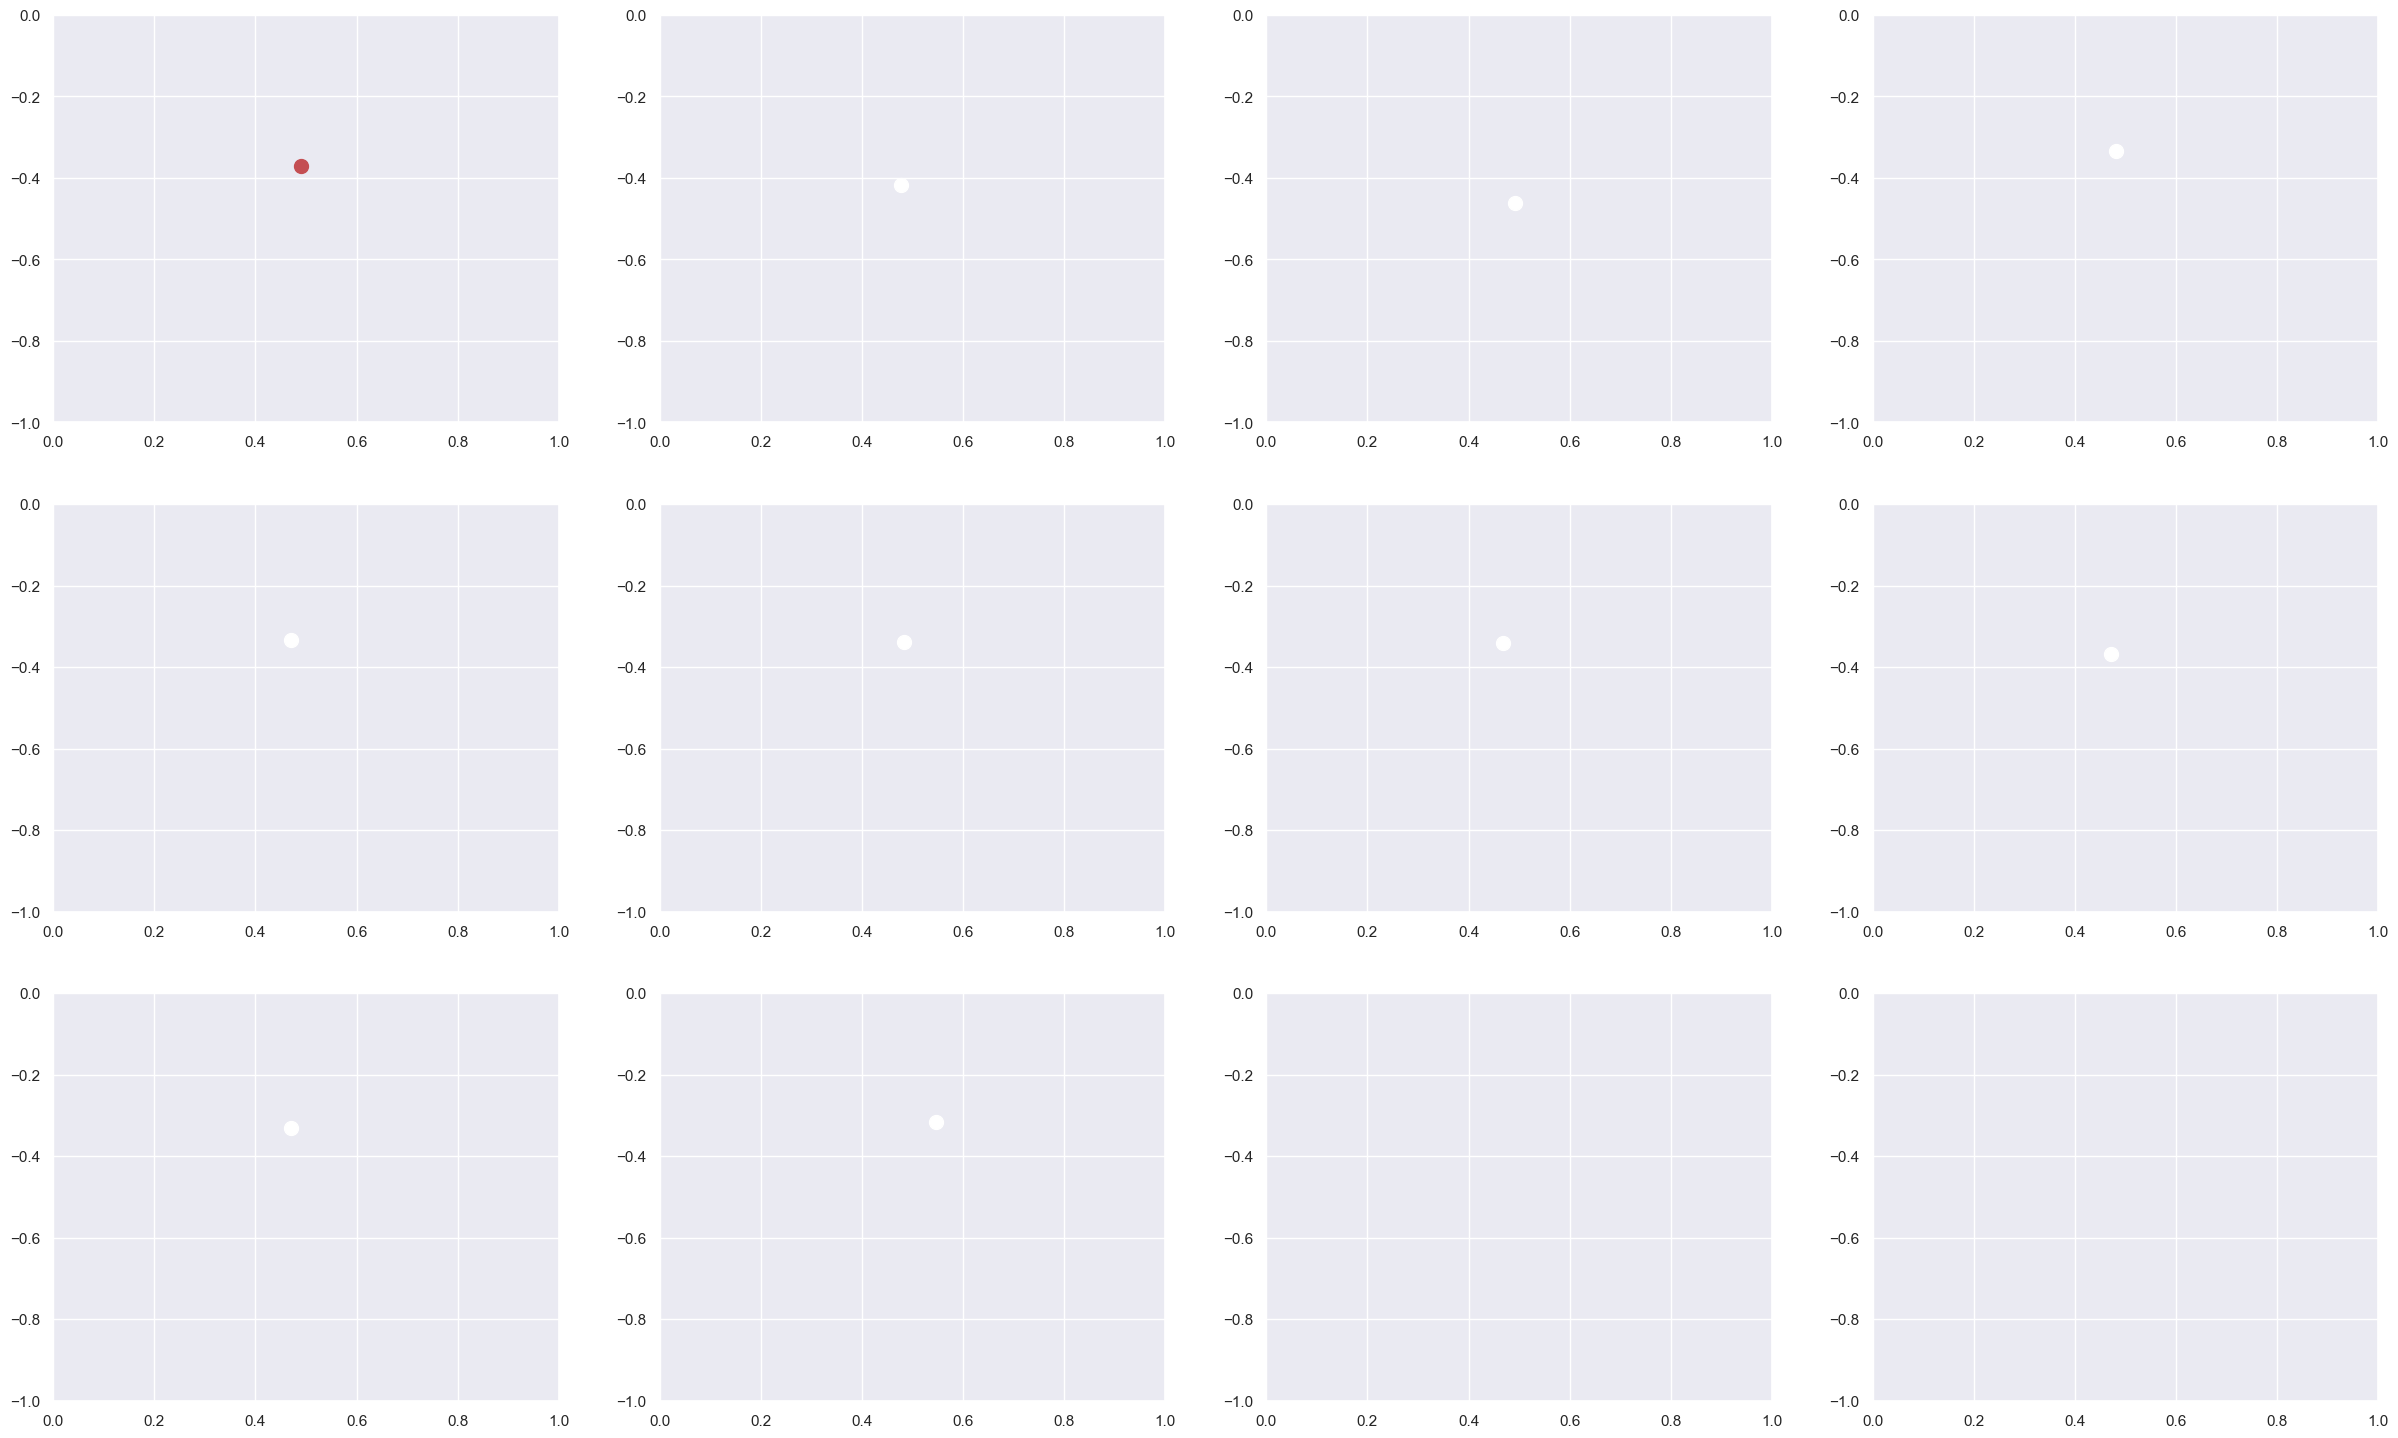

In [16]:
# Video of averaged patterns
sns.set(rc={'figure.figsize':(30,18)})
fig, axs = plt.subplots(3, 4)
for ax in axs.flat:
    ax.set_xlim([0,1])
    ax.set_ylim([-1,0])
lines = [ax.plot(x[0], -y[0], 'o', color='r', markersize=10)[0] for ax, x, y in zip(axs.flat, snippet_xavg, snippet_yavg)]
def update(frame):
    for line, x, y in zip(lines, snippet_xavg, snippet_yavg):
        try:
            line.set_xdata(x[frame])
            line.set_ydata(-y[frame])
        except:
            line.set_color('white')
    return lines
ani = animation.FuncAnimation(fig, update, frames=np.arange(max(map(len, snippet_xavg))), blit=True)
ani.save('extracted_patterns_dtw_avg.mp4', writer=animation.FFMpegWriter(fps=20))